### Analyze csv data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns
import geopandas as gpd
import requests
import numpy as np
import math
import gc
import json
import re
import keplergl as kp
import glob
import os
import ast
import movingpandas as mpd
import pyproj

from pymeos import *
from tqdm.notebook import tqdm
from shapely.geometry import LineString, Point
from sklearn import metrics
from datetime import datetime, timedelta
from scipy import stats
from ast import literal_eval
from geopy.distance import geodesic
from itertools import groupby
from operator import itemgetter

SIGNALS = ['lastDayTotalConsumedEnergy']
from shapely import wkt, get_srid, set_srid
tqdm.pandas()
pymeos_initialize()

In [15]:
%matplotlib inline
sns.set(rc = {'figure.figsize': (8,5)})

### Common utilities
This is for common utilities used in this notebooks

#### Map matching utilities

In [16]:
##six degrees of precision in valhalla
inv = 1.0 / 1e6;

#decode an encoded string
def decode(encoded):
  decoded = []
  previous = [0,0]
  i = 0
  #for each byte
  while i < len(encoded):
    #for each coord (lat, lon)
    ll = [0,0]
    for j in [0, 1]:
      shift = 0
      byte = 0x20
      #keep decoding bytes until you have this coord
      while byte >= 0x20:
        byte = ord(encoded[i]) - 63
        i += 1
        ll[j] |= (byte & 0x1f) << shift
        shift += 5
      #get the final value adding the previous offset and remember it for the next
      ll[j] = previous[j] + (~(ll[j] >> 1) if ll[j] & 1 else (ll[j] >> 1))
      previous[j] = ll[j]
    #scale by the precision and chop off long coords also flip the positions so
    #its the far more standard lon,lat instead of lat,lon
    decoded.append([float('%.6f' % (ll[1] * inv)), float('%.6f' % (ll[0] * inv))])
  #hand back the list of coordinates
  return decoded


def map_matching_v2(df):
    meili_coordinates = df.to_json(orient='records')
    meili_head = '{"shape":'
    meili_tail = ""","search_radius": 10, "shape_match":"map_snap", "costing":"bus", "format":"osrm"}"""
    meili_request_body = meili_head + meili_coordinates + meili_tail
    url = "http://localhost:8002/trace_attributes"
    headers = {'Content-type': 'application/json'}
    data = str(meili_request_body)

    r = requests.post(url, data=data, headers=headers)
    
    if r.status_code == 200:
        response_text = json.loads(r.text)

        resp = json.dumps(response_text['matched_points'])
        resp = resp.replace("None", "{'lon': 0.0, 'lat': 0.0, 'type': '',"
                                        " 'edge_index': 'NaN', 'distance_along_edge': 0.0, 'distance_from_trace_point': 0.0}")
        resp = resp.replace("'", '"')
        resp = re.sub(r'(:\s+"[^"]*)"(?=[^"]*",)', r'\1\"', resp)\
        
        way_ids = [edge['way_id'] for edge in response_text['edges']]
        length = [edge['length'] for edge in response_text['edges']]
        
        matched_df = df.copy()
        matched_df['way_ids'] =  np.empty((len(matched_df), 0)).tolist()
        matched_df['new_lat'] = np.nan
        matched_df['new_lon'] = np.nan
        matched_df['length'] = np.empty((len(matched_df), 0)).tolist()
        matched_df['distance_along_edge'] = np.nan

        df_response = pd.read_json(resp)

        try:
            for i in range(len(df_response)):
                # Only get matched point from the map matched result
                if df_response['type'].iat[i] != 'matched':
                    continue

                # This is to get the next matched index
                j = i + 1
                while(j < len(df_response) - 2 and df_response['type'].iat[j] != 'matched'):
                    j += 1


                # This is to get traversed road segment between current point and the next point
                start_idx = int(df_response['edge_index'].iat[i])
                if (i == len(df_response) - 1) or math.isnan(df_response['edge_index'].iat[j]):
                    end_idx = start_idx + 1
                else:
                    end_idx = int(df_response['edge_index'].iat[j] + 1)

                matched_df['new_lon'].iat[i] = df_response['lon'].iat[i]
                matched_df['new_lat'].iat[i] = df_response['lat'].iat[i]
                matched_df['distance_along_edge'].iat[i] = df_response['distance_along_edge'].iat[i]
                matched_df['way_ids'].iat[i] = list(dict.fromkeys(way_ids[start_idx:end_idx]))

                # Sum the traversed length between point
                length_map = {}
                for idx in range(start_idx, end_idx):
                    length_map.setdefault(way_ids[idx], 0)
                    length_map[way_ids[idx]] += length[idx]

                matched_df['length'].iat[i]= length_map
        except Exception:
            return matched_df
            
        return matched_df
        
def process_vehicle_data(vehicle, battery_df):
    vehicle_data = []
    
    # Filter data for the specific vehicle
    vehicle_df = battery_df[battery_df['vehicle'] == vehicle]
    
    # Iterate over unique dates in the 'time' column
    unique_dates = vehicle_df['t'].dt.date.unique()

    for date in unique_dates:
        daily_df = vehicle_df[vehicle_df['t'].dt.date == date]
        trip_ids = daily_df['trip_id'].unique()
        
        for trip_id in trip_ids:
            filtered_df = daily_df[daily_df['trip_id'] == trip_id]
            filtered_df = filtered_df.rename(columns={'latitude': 'lat', 'longitude': 'lon', 't': 'time'})

            if not filtered_df.empty:
                map_df_opt = map_matching_v2(filtered_df)
                if map_df_opt is not None:
                    map_df_opt = map_df_opt.reset_index(drop=True)
                    map_df_opt = map_df_opt[(map_df_opt['new_lat'].notna()) & (map_df_opt['new_lon'].notna())]
                vehicle_data.append(map_df_opt)
                del map_df_opt  # Free memory
        
        del daily_df  # Free memory
        
    return vehicle_data

def map_match_and_merge(battery_df, vehicles=[]):
    all_data = []

    for vehicle in vehicles:
        vehicle_data = process_vehicle_data(vehicle, battery_df)
        all_data.extend(vehicle_data)
        del vehicle_data  # Free memory
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    return combined_df


### Read the raw bus trajectories

In [17]:
battery_df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('../data', "*.csv"))))
battery_df = battery_df.rename(columns={'Segnale': 'signal', 'Valore': 'value', 'DataOra': 't', 'Latitudine': 'latitude', 'Veicolo': 'vehicle', 'Longitudine': 'longitude'})
battery_df = battery_df[(battery_df["longitude"] >= 5.93) & (battery_df["longitude"] <= 18.99)]
battery_df = battery_df[(battery_df["latitude"] >= 34.76) & (battery_df["latitude"] <= 47.1)]

consumption_df = battery_df[battery_df['signal'] == 'lastDayTotalConsumedEnergy']
consumption_df['t'] = pd.to_datetime(consumption_df['t'])
consumption_df['date'] = consumption_df['t'].dt.date
consumption_df = consumption_df.sort_values(by=['vehicle', 't'])

/tmp/ipykernel_19795/2861311264.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_df['t'] = pd.to_datetime(consumption_df['t'])
/tmp/ipykernel_19795/2861311264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_df['date'] = consumption_df['t'].dt.date


### Exclude dates with reset battery consumption for analysis and dataset

We need to remove dates with the battery consumption reset in the same day for now, since it will affect the current interpolation techniques. We will save the dates and vehicle ID when the resets happened

In [18]:
# Group by vehicle and identify resets
def identify_resets(group):
    group = group.sort_values(['t'])
    group['previous_value'] = group['value'].shift(1).fillna(0)
    reset_dates = group[(group['value'] == 0) & (group['previous_value'] > 0)]
    return reset_dates

reset_dates = consumption_df.groupby(['vehicle', 'date']).apply(identify_resets).reset_index(drop=True)

# Get the unique dates and vehicles where reset occurs
reset_dates_info = reset_dates[['vehicle', 'date']].drop_duplicates()

/tmp/ipykernel_19795/836423154.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reset_dates = consumption_df.groupby(['vehicle', 'date']).apply(identify_resets).reset_index(drop=True)


### Transform the coordinates into the correct EPSG
This is needed to calculate the stay points detection

In [19]:
# Function to project coordinates from EPSG:4326 to EPSG:6875
def project_coords(lon, lat):
    x, y = proj_4326_to_6875.transform(lon, lat)
    return x, y

# Apply the projection to the latitude and longitude columns
projected_coords = consumption_df.apply(lambda row: project_coords(row['longitude'], row['latitude']), axis=1)
consumption_df['x'], consumption_df['y'] = zip(*projected_coords)
consumption_df

,vehicle,t,signal,value,latitude,longitude,date,x,y
2164,E301,2024-01-21 08:16:26,lastDayTotalConsumedEnergy,0.0,44.399420,8.947543,2024-01-21,6.757185e+06,4.915355e+06
2165,E301,2024-01-21 08:18:27,lastDayTotalConsumedEnergy,0.0,44.399490,8.947536,2024-01-21,6.757184e+06,4.915362e+06
2166,E301,2024-01-21 08:18:58,lastDayTotalConsumedEnergy,0.0,44.399494,8.947528,2024-01-21,6.757184e+06,4.915363e+06
2167,E301,2024-01-21 08:19:28,lastDayTotalConsumedEnergy,0.0,44.399498,8.947540,2024-01-21,6.757185e+06,4.915363e+06
2168,E301,2024-01-21 08:40:40,lastDayTotalConsumedEnergy,0.0,44.399555,8.947470,2024-01-21,6.757179e+06,4.915370e+06
...,...,...,...,...,...,...,...,...,...
43752,E316,2024-02-09 21:02:04,lastDayTotalConsumedEnergy,163.0,44.398500,8.948981,2024-02-09,6.757295e+06,4.915248e+06
43753,E316,2024-02-09 21:02:35,lastDayTotalConsumedEnergy,163.0,44.398598,8.947336,2024-02-09,6.757165e+06,4.915264e+06
43754,E316,2024-02-09 21:03:06,lastDayTotalConsumedEnergy,163.0,44.399197,8.946649,2024-02-09,6.757113e+06,4.915333e+06
43755,E316,2024-02-09 21:03:36,lastDayTotalConsumedEnergy,163.0,44.399624,8.946854,2024-02-09,6.757131e+06,4.915379e+06


### Segment Trajectory to assign Trip ID
Utilize stop points detection to detect the stop points, and segment the trajectories based on those stop points

In [20]:
consumption_gdf = gpd.GeoDataFrame(consumption_df, geometry=gpd.points_from_xy(consumption_df['longitude'], consumption_df['latitude']), crs='EPSG:4326')
consumption_gdf = consumption_gdf.to_crs("EPSG:6875")
consumption_gdf

,vehicle,t,signal,value,latitude,longitude,date,x,y,geometry
2164,E301,2024-01-21 08:16:26,lastDayTotalConsumedEnergy,0.0,44.399420,8.947543,2024-01-21,6.757185e+06,4.915355e+06,POINT (6757184.664 4915354.657)
2165,E301,2024-01-21 08:18:27,lastDayTotalConsumedEnergy,0.0,44.399490,8.947536,2024-01-21,6.757184e+06,4.915362e+06,POINT (6757184.397 4915362.445)
2166,E301,2024-01-21 08:18:58,lastDayTotalConsumedEnergy,0.0,44.399494,8.947528,2024-01-21,6.757184e+06,4.915363e+06,POINT (6757183.778 4915362.912)
2167,E301,2024-01-21 08:19:28,lastDayTotalConsumedEnergy,0.0,44.399498,8.947540,2024-01-21,6.757185e+06,4.915363e+06,POINT (6757184.749 4915363.321)
2168,E301,2024-01-21 08:40:40,lastDayTotalConsumedEnergy,0.0,44.399555,8.947470,2024-01-21,6.757179e+06,4.915370e+06,POINT (6757179.416 4915369.853)
...,...,...,...,...,...,...,...,...,...,...
43752,E316,2024-02-09 21:02:04,lastDayTotalConsumedEnergy,163.0,44.398500,8.948981,2024-02-09,6.757295e+06,4.915248e+06,POINT (6757295.249 4915248.310)
43753,E316,2024-02-09 21:02:35,lastDayTotalConsumedEnergy,163.0,44.398598,8.947336,2024-02-09,6.757165e+06,4.915264e+06,POINT (6757164.795 4915264.065)
43754,E316,2024-02-09 21:03:06,lastDayTotalConsumedEnergy,163.0,44.399197,8.946649,2024-02-09,6.757113e+06,4.915333e+06,POINT (6757112.624 4915332.568)
43755,E316,2024-02-09 21:03:36,lastDayTotalConsumedEnergy,163.0,44.399624,8.946854,2024-02-09,6.757131e+06,4.915379e+06,POINT (6757130.700 4915379.337)


In [21]:
def get_stop_split(group):
    group['stop'] = False
    tc = mpd.TrajectoryCollection(group, 'vehicle', t='t')
    detector = mpd.TrajectoryStopDetector(tc)
    stop_time_ranges = detector.get_stop_time_ranges(min_duration=timedelta(seconds=240), max_diameter=100)
    for x in stop_time_ranges:
        group.loc[(group['vehicle'] == x.traj_id) & (group['t'] >= x.t_0) & (group['t'] <= x.t_n), 'stop'] = True
    return group

consumption_gdf = consumption_gdf.groupby('date').apply(get_stop_split).reset_index(drop=True)

/tmp/ipykernel_19795/3805774413.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consumption_gdf = consumption_gdf.groupby('date').apply(get_stop_split).reset_index(drop=True)


### Assign Trip Id based on the stop points

In [22]:
# Assign trip_id for non-stop values
def assign_non_stop_trip_ids(group):
    # Create trip_id by incrementing on transitions from stop to non-stop
    group['trip_id'] = (group['stop'] == True).cumsum()
    return group

# Apply the function to assign trip_ids for non-stop values
df_non_stop = consumption_gdf.groupby(['vehicle', 'date']).apply(assign_non_stop_trip_ids).reset_index(drop=True)
df_non_stop = df_non_stop[df_non_stop['stop'] == False]

/tmp/ipykernel_19795/2760135968.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_non_stop = consumption_gdf.groupby(['vehicle', 'date']).apply(assign_non_stop_trip_ids).reset_index(drop=True)


In [23]:
# Assign trip_id for stop values
def assign_stop_trip_ids(group):
    group = group.copy()
    # Initialize trip_id
    trip_id = 0
    trip_ids = []
    for i in range(len(group)):
        if i > 0 and not group.iloc[i-1]['stop']:
            trip_id += 1
        trip_ids.append(trip_id)
    group['trip_id'] = trip_ids
    return group


# Apply the function to assign trip_ids for stop values
df_stop = consumption_gdf.groupby(['vehicle', 'date']).apply(assign_stop_trip_ids).reset_index(drop=True)
df_stop = df_stop[df_stop['stop'] == True]

/tmp/ipykernel_19795/4205172751.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stop = consumption_gdf.groupby(['vehicle', 'date']).apply(assign_stop_trip_ids).reset_index(drop=True)


In [24]:
# Merge the dataframes back together
consumption_gdf = pd.concat([df_non_stop, df_stop]).sort_index()

# Prefix trip_ids
consumption_gdf.loc[consumption_gdf['stop'] == False, 'trip_id'] = 'trip_' + consumption_gdf['trip_id'].astype(str)
consumption_gdf.loc[consumption_gdf['stop'] == True, 'trip_id'] = 'stop_' + consumption_gdf['trip_id'].astype(str)

# Sort the DataFrame by original order
consumption_gdf = consumption_gdf.sort_values(by=['vehicle', 't']).reset_index(drop=True)

/tmp/ipykernel_19795/1066947901.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['trip_20' 'trip_20' 'trip_20' ... 'trip_490' 'trip_490' 'trip_490']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  consumption_gdf.loc[consumption_gdf['stop'] == False, 'trip_id'] = 'trip_' + consumption_gdf['trip_id'].astype(str)


### Assign speed based on trip

In [9]:
consumption_gdf.to_csv('../processed_data/trip_id.csv', index=False)

In [25]:
consumption_df = pd.DataFrame(consumption_gdf.drop(columns=['geometry', 'stop']))
consumption_df

,vehicle,t,signal,value,latitude,longitude,date,x,y,trip_id
0,E301,2024-01-21 08:16:26,lastDayTotalConsumedEnergy,0.0,44.399420,8.947543,2024-01-21,6.757185e+06,4.915355e+06,stop_0
1,E301,2024-01-21 08:18:27,lastDayTotalConsumedEnergy,0.0,44.399490,8.947536,2024-01-21,6.757184e+06,4.915362e+06,stop_0
2,E301,2024-01-21 08:18:58,lastDayTotalConsumedEnergy,0.0,44.399494,8.947528,2024-01-21,6.757184e+06,4.915363e+06,stop_0
3,E301,2024-01-21 08:19:28,lastDayTotalConsumedEnergy,0.0,44.399498,8.947540,2024-01-21,6.757185e+06,4.915363e+06,stop_0
4,E301,2024-01-21 08:40:40,lastDayTotalConsumedEnergy,0.0,44.399555,8.947470,2024-01-21,6.757179e+06,4.915370e+06,stop_0
...,...,...,...,...,...,...,...,...,...,...
313235,E316,2024-02-09 21:02:04,lastDayTotalConsumedEnergy,163.0,44.398500,8.948981,2024-02-09,6.757295e+06,4.915248e+06,trip_490
313236,E316,2024-02-09 21:02:35,lastDayTotalConsumedEnergy,163.0,44.398598,8.947336,2024-02-09,6.757165e+06,4.915264e+06,trip_490
313237,E316,2024-02-09 21:03:06,lastDayTotalConsumedEnergy,163.0,44.399197,8.946649,2024-02-09,6.757113e+06,4.915333e+06,trip_490
313238,E316,2024-02-09 21:03:36,lastDayTotalConsumedEnergy,163.0,44.399624,8.946854,2024-02-09,6.757131e+06,4.915379e+06,trip_490


### Map Macthed the Trajectory;

Map matching is the first step to this data preprocessing, it will map matched the trajectories per (vehicle, date). The result will be map matched points and also information regarding traversed roas

In [37]:
vehicles = consumption_gdf['vehicle'].unique()
map_matched_df = map_match_and_merge(consumption_df, vehicles)

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122376.py:62: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_response = pd.read_json(resp)
/tmp/ipykernel_13058/1371122

In [39]:
map_matched_df.head(60)

,vehicle,time,signal,value,lat,lon,date,trip_id,way_ids,new_lat,new_lon,length,distance_along_edge
0,E301,2024-01-21 08:48:48,lastDayTotalConsumedEnergy,0.0,44.400116,8.946082,2024-01-21,trip_20,[553983725],44.400228,8.945580,{553983725: 0.014},0.000000
1,E301,2024-01-21 08:49:19,lastDayTotalConsumedEnergy,0.0,44.400210,8.945732,2024-01-21,trip_20,"[553983725, 211285373]",44.400242,8.945586,"{553983725: 0.014, 211285373: 0.064}",0.116126
2,E301,2024-01-21 08:49:49,lastDayTotalConsumedEnergy,1.0,44.400738,8.945725,2024-01-21,trip_20,"[211285373, 19784065, 474230989, 553819742]",44.400717,8.945807,"{211285373: 0.064, 19784065: 0.049, 474230989:...",0.673859
3,E301,2024-01-21 08:50:19,lastDayTotalConsumedEnergy,1.0,44.401930,8.946167,2024-01-21,trip_20,"[553819742, 557313439]",44.401896,8.946151,"{553819742: 0.074, 557313439: 0.032}",0.742558
4,E301,2024-01-21 08:50:50,lastDayTotalConsumedEnergy,2.0,44.401833,8.945853,2024-01-21,trip_20,"[557313439, 53817770, 53817787]",44.401820,8.945904,"{557313439: 0.032, 53817770: 0.005, 53817787: ...",0.178238
5,E301,2024-01-21 08:51:21,lastDayTotalConsumedEnergy,2.0,44.401287,8.945581,2024-01-21,trip_20,[53817787],44.401272,8.945637,{53817787: 0.067},0.489409
6,E301,2024-01-21 08:52:23,lastDayTotalConsumedEnergy,3.0,44.397710,8.943308,2024-01-21,trip_20,[278624956],44.397696,8.943352,{278624956: 0.229},0.266320
7,E301,2024-01-21 08:52:53,lastDayTotalConsumedEnergy,4.0,44.397778,8.939562,2024-01-21,stop_8,[75464868],44.397788,8.939564,{75464868: 0.002},0.213572
8,E301,2024-01-21 09:00:02,lastDayTotalConsumedEnergy,6.0,44.397770,8.939533,2024-01-21,stop_8,[75464868],44.397791,8.939537,{75464868: 0.002},0.243834
9,E301,2024-01-21 09:00:33,lastDayTotalConsumedEnergy,7.0,44.397892,8.942510,2024-01-21,trip_35,"[62223221, 19784323]",44.397872,8.942523,"{62223221: 0.126, 19784323: 0.304}",0.107708


In [40]:
map_matched_df = map_matched_df.rename(columns={'time': 't', 'lat': 'latitude', 'lon': 'longitude'})
map_matched_df.to_csv('../processed_data/map_matched_by_trips.csv', index=False)

### Estimate the kwh
This is the steps necessary to get estimated kwh for each vehicle per day. Basically this is done by doing linear interpolation of the consumption value from the map matched dataset and then by trying to get each segment estimated consumption.

#### Common utils for estimated kwh

In [26]:
def add_gap_id(consumption_data):
    consumption_data = consumption_data.sort_values(by=['vehicle', 't'])
    consumption_data['time_diff'] = consumption_data.groupby('vehicle')['t'].diff().dt.total_seconds() / 60.0
    consumption_data['gap_id'] = (consumption_data['time_diff'] > 4).groupby(consumption_data['vehicle']).cumsum() + 1
    return consumption_data.drop(columns=['time_diff'])

def transform_to_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['new_lon'], df['new_lat']), crs='EPSG:4326')
    gdf.drop(columns=['latitude', 'longitude', 'new_lat', 'new_lon'], inplace=True)
    return gdf.sort_values(by=['vehicle', 't'])

def convert_length(data_str):
    data_dict = ast.literal_eval(data_str)
    if isinstance(data_dict, list):
        return []
    data_list = [(k, v) for k, v in data_dict.items()]
    return data_list[:-1] if len(data_list) > 1 else data_list  # Convert the dictionary to a list of dictionaries

#### Read the map matched data and tidy up the data type inside the raw csv file

In [32]:
consumption_data = pd.read_csv('../processed_data/map_matched_bus_v2.csv')
consumption_data['t'] = pd.to_datetime(consumption_data['t'])

# Adjust way_ids and length by removin last point (because it is belong to next point)
consumption_data['way_ids'] = consumption_data['way_ids'].apply(literal_eval).apply(lambda x: x[:-1] if len(x) > 1 else x)
consumption_data['length'] = consumption_data['length'].apply(convert_length)
consumption_data['date'] = consumption_data['t'].dt.date

# This is to fix inconsistency in the dataset, assuming that the data will always increase
consumption_data = consumption_data.sort_values(by=['vehicle', 'date', 't'])
consumption_data['value'] = consumption_data.groupby(by=['vehicle', 'date'])['value'].transform(lambda x: x.cummax())

#### Getting missing consumption at the start of the data
Because of the map matching we could lose some informations regarding the battery consumption, so this is done to even out the starting point of the consumption. So intead of starting at X, we need to start at 0

In [33]:
consumption_gdf = pd.read_csv('../processed_data/trip_id.csv')
consumption_gdf['t'] = pd.to_datetime(consumption_gdf['t'])
consumption_data = pd.merge(consumption_data, consumption_gdf[['vehicle', 't', 'trip_id']], on=['vehicle', 't'])

In [34]:
consumption_matched_gdf = pd.merge(consumption_matched_gdf, consumption_diff[['vehicle', 'date', 'diff']], on=['vehicle', 'date'], how='left')
consumption_matched_gdf['value'] = consumption_matched_gdf.apply(lambda row: row['value'] - row['diff'], axis=1)
consumption_matched_gdf

NameError: name 'consumption_matched_gdf' is not defined

In [ ]:
consumption_data

In [9]:
consumption_data

,vehicle,t,signal,value,latitude,longitude,way_ids,new_lat,new_lon,length,distance_along_edge,date,trip_id,assigned_id
0,E302,2024-02-01 07:34:46,lastDayTotalConsumedEnergy,1.0,44.400260,8.945720,[553983725],44.400285,8.945605,"[(553983725, 0.007)]",0.464135,2024-02-01,trip_16,2024-02-01_1
1,E302,2024-02-01 07:35:17,lastDayTotalConsumedEnergy,1.0,44.400845,8.945828,"[211285373, 19784065, 474230989, 53817661, 669...",44.400836,8.945864,"[(211285373, 0.064), (19784065, 0.049), (47423...",0.891801,2024-02-01,trip_16,2024-02-01_1
2,E302,2024-02-01 07:35:47,lastDayTotalConsumedEnergy,2.0,44.402958,8.946772,[813150626],44.402946,8.946820,"[(813150626, 0.22)]",0.457453,2024-02-01,trip_16,2024-02-01_1
3,E302,2024-02-01 07:36:18,lastDayTotalConsumedEnergy,2.0,44.404170,8.947173,"[700549200, 19784075]",44.404013,8.947095,"[(700549200, 0.022), (19784075, 0.01)]",0.756225,2024-02-01,trip_16,2024-02-01_1
4,E302,2024-02-01 07:37:20,lastDayTotalConsumedEnergy,2.0,44.404230,8.946823,"[557318844, 810459286, 1210150431, 5240525, 10...",44.404105,8.946751,"[(557318844, 0.044), (810459286, 0.042), (1210...",0.308572,2024-02-01,trip_16,2024-02-01_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84708,E316,2024-02-09 20:59:31,lastDayTotalConsumedEnergy,163.0,44.403126,8.951199,[24313581],44.403127,8.951190,"[(24313581, 0.171)]",0.883344,2024-02-09,trip_490,2024-02-09_1
84709,E316,2024-02-09 21:00:01,lastDayTotalConsumedEnergy,163.0,44.402260,8.950765,[136531734],44.402255,8.950784,"[(136531734, 0.146)]",0.563632,2024-02-09,trip_490,2024-02-09_1
84710,E316,2024-02-09 21:00:32,lastDayTotalConsumedEnergy,163.0,44.401497,8.950438,[274100607],44.401498,8.950430,"[(274100607, 0.098)]",0.254355,2024-02-09,trip_490,2024-02-09_1
84711,E316,2024-02-09 21:01:03,lastDayTotalConsumedEnergy,163.0,44.401000,8.950189,"[274100607, 274100606]",44.400998,8.950195,"[(274100607, 0.098), (274100606, 0.108)]",0.853612,2024-02-09,trip_490,2024-02-09_1


#### Convert the data as gdf

##### Common utilities for calculating the consumption

In [14]:
'''
    Add the ending bound for each point, this is to create bounding between value.
    Let say we have 5 values of 0 and the timestamps associated with it. 
    This will add the timestamp for the next value, to create bounding of this value.
    This is important as it will be used the get interpolated point.
'''
def add_ending_bounds(df, column):
    df[f'next_{column}'] = df[column].shift(-1).apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

    # Step 2: Append this 'next_first_point' to the current 'points' list
    df[column] = df.apply(lambda row: row[column] + [row[f'next_{column}']] if pd.notnull(row[f'next_{column}']) else row[column], axis=1)

    # Optionally, drop the 'next_first_point' column if it's no longer needed
    return df.drop(columns=f'next_{column}')

'''
    This is done to adjust bounding of time. Since there will be the case where the value only consisted of one row.
    It is necessary to add dummy bound in order to avoid error when interpolating the data.
'''
def adjust_last_time_bound(times):
    if times[0] == times[-1]:
        return [times[0], times[0] + pd.Timedelta(seconds=30)]
    return [times[0], times[-1]]

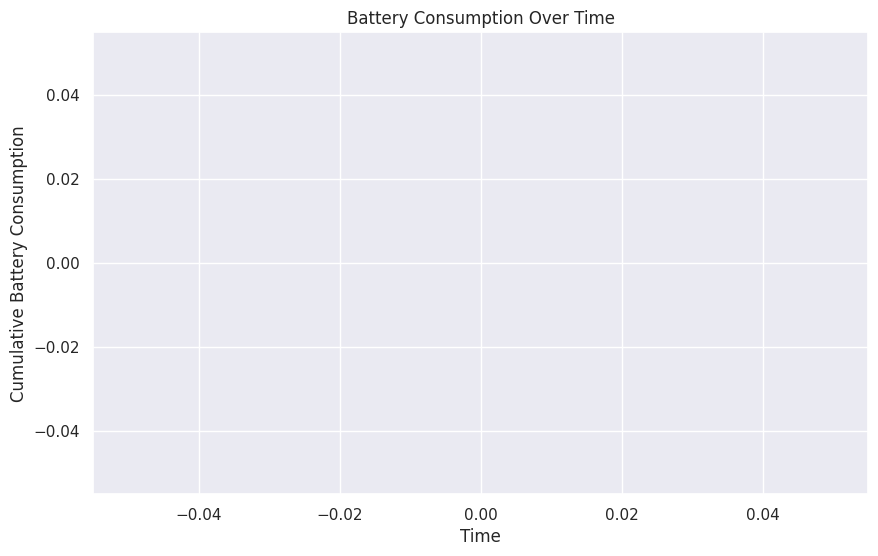

In [22]:
data = consumption_data[(consumption_data['vehicle'] == 'E302') & (consumption_data['date'] == pd.to_datetime('2024-01-26').date())]

# Plot the value of 'value' over 't' using a lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='t', y='value')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Cumulative Battery Consumption')
plt.title('Battery Consumption Over Time')

plt.savefig('battery-consumption.png', format='png')
# Display the plot
plt.show()

In [13]:
# Transforming the data to geoddataframe, this will be used to clean up the latitude and longitude to geometry object
consumption_matched_gdf = transform_to_gdf(consumption_data)

In [144]:
# all_points = consumption_gdf[(consumption_gdf['vehicle'] == 'E301') & (consumption_gdf['date'] == pd.to_datetime('2024-01-21').date())]
matched = consumption_matched_gdf[(consumption_matched_gdf['vehicle'] == 'E301') & (consumption_matched_gdf['date'] == pd.to_datetime('2024-01-21').date())]
# all_points = pd.merge(all_points, matched, on=['vehicle', 't'], how='left')
# all_points = all_points[(all_points['geometry_y']).notna()].rename(columns={'geometry_x': 'geometry'})


# Pick the first 4 unique trips
first_4_trips = matched['trip_id'].unique()[:6]

# Filter matched data to include only the first 4 trips
matched_first_4 = matched[matched['trip_id'].isin(first_4_trips)]

# Function to create LineString if there are multiple points
def create_linestring(group):
    if len(group) > 1:
        return LineString(group.sort_values('t')['geometry'].tolist())
    else:
        return group.iloc[0]['geometry']

# Group by trip_id and apply the function
linestrings = matched_first_4.groupby('trip_id').apply(create_linestring).reset_index()
linestrings.columns = ['trip_id', 'geometry']

# Merge the original data to retain other columns
merged_gdf = pd.merge(linestrings, matched_first_4[['trip_id', 't', 'value']], on='trip_id')

# Create a GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

import keplergl as kp
map_1 = kp.KeplerGl(height=600, data=
                    {'matched': merged_gdf[['t', 'value', 'geometry', 'trip_id']]})
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/tmp/ipykernel_13058/514400516.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  linestrings = matched_first_4.groupby('trip_id').apply(create_linestring).reset_index()


KeplerGl(data={'matched':                       t  value  \
0   2024-01-21 10:07:52   29.0   
1   2024-01-21 1…

In [15]:
result = consumption_matched_gdf.copy()

# Group by value and create lower and upper bound for each value
result = result.sort_values(['vehicle', 't'])
traj = result.groupby(['vehicle', 'date', 'value']).aggregate(
    {
        "geometry": list,
        "way_ids": list,
        "length": list,
        "t": list,
        "distance_along_edge": list,
        "trip_id": list,
    }
).reset_index()

traj = traj.groupby(['vehicle', 'date']).apply(lambda group: add_ending_bounds(group, 't')).reset_index(drop=True)

traj['value_bounds'] = traj['value'].apply(lambda x: [x, x+1])
traj['time_bounds'] = traj['t'].apply(adjust_last_time_bound)
traj

/tmp/ipykernel_43434/472580823.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  traj = traj.groupby(['vehicle', 'date']).apply(lambda group: add_ending_bounds(group, 't')).reset_index(drop=True)


,vehicle,date,value,geometry,way_ids,length,t,distance_along_edge,trip_id,value_bounds,time_bounds
0,E301,2024-01-21,0.0,"[POINT (8.94558 44.400228), POINT (8.945586 44...","[[553983725], [553983725]]","[[(553983725, 0.014)], [(553983725, 0.014)]]","[2024-01-21 08:48:48, 2024-01-21 08:49:19, 202...","[0.0, 0.116126]","[trip_20, trip_20]","[0.0, 1.0]","[2024-01-21 08:48:48, 2024-01-21 08:49:49]"
1,E301,2024-01-21,1.0,"[POINT (8.945807 44.400717), POINT (8.946151 4...","[[211285373, 19784065, 474230989], [553819742]]","[[(211285373, 0.064), (19784065, 0.049), (4742...","[2024-01-21 08:49:49, 2024-01-21 08:50:19, 202...","[0.673859, 0.7425579999999999]","[trip_20, trip_20]","[1.0, 2.0]","[2024-01-21 08:49:49, 2024-01-21 08:50:50]"
2,E301,2024-01-21,2.0,"[POINT (8.945904 44.40182), POINT (8.945637 44...","[[557313439, 53817770], [53817787, 19639754, 4...","[[(557313439, 0.032), (53817770, 0.005)], [(53...","[2024-01-21 08:50:50, 2024-01-21 08:51:21, 202...","[0.1782379999999999, 0.489409]","[trip_20, trip_20]","[2.0, 3.0]","[2024-01-21 08:50:50, 2024-01-21 08:52:23]"
3,E301,2024-01-21,3.0,[POINT (8.943352 44.397696)],[[278624956]],"[[(278624956, 0.863)]]","[2024-01-21 08:52:23, 2024-01-21 08:52:53]",[0.26632],[trip_20],"[3.0, 4.0]","[2024-01-21 08:52:23, 2024-01-21 08:52:53]"
4,E301,2024-01-21,4.0,[POINT (8.939486 44.397631)],[[278624956]],"[[(278624956, 0.863)]]","[2024-01-21 08:52:53, 2024-01-21 09:00:33]",[0.700172],[stop_8],"[4.0, 5.0]","[2024-01-21 08:52:53, 2024-01-21 09:00:33]"
...,...,...,...,...,...,...,...,...,...,...,...
29825,E316,2024-02-09,158.0,"[POINT (8.966978 44.404801), POINT (8.967889 4...","[[153650623], [150831979]]","[[(153650623, 0.21)], [(150831979, 0.668)]]","[2024-02-09 20:36:34, 2024-02-09 20:37:04, 202...","[0.8455929999999999, 0.062975]","[trip_490, trip_490]","[158.0, 159.0]","[2024-02-09 20:36:34, 2024-02-09 20:37:35]"
29826,E316,2024-02-09,159.0,"[POINT (8.971085 44.405949), POINT (8.974416 4...","[[150831979], [150831979, 53099942], [13245254]]","[[(150831979, 0.668)], [(150831979, 0.668), (5...","[2024-02-09 20:37:35, 2024-02-09 20:38:05, 202...","[0.501158, 0.934674, 0.181399]","[trip_490, trip_490, trip_490]","[159.0, 160.0]","[2024-02-09 20:37:35, 2024-02-09 20:39:06]"
29827,E316,2024-02-09,160.0,"[POINT (8.976874 44.40651), POINT (8.977109 44...","[[13245254], [13245254, 13861065, 675783701, 1...","[[(13245254, 0.304)], [(13245254, 0.304), (138...","[2024-02-09 20:39:06, 2024-02-09 20:39:37, 202...","[0.553341, 0.9915, 0.205454, 0.130931, 0.34107...","[trip_490, trip_490, trip_490, trip_490, trip_...","[160.0, 161.0]","[2024-02-09 20:39:06, 2024-02-09 20:48:17]"
29828,E316,2024-02-09,161.0,"[POINT (8.98251 44.405346), POINT (8.980409 44...","[[157858535], [157858535, 970431881], [5549788...","[[(157858535, 0.384)], [(157858535, 0.384), (9...","[2024-02-09 20:48:17, 2024-02-09 20:48:48, 202...","[0.2352389999999999, 0.877354, 0.870536, 0.335...","[trip_490, trip_490, trip_490, trip_490]","[161.0, 162.0]","[2024-02-09 20:48:17, 2024-02-09 20:50:20]"


In [16]:
# This will convert the value bounds and time bounds into TFloatInst, this enable us to do linear interpolation
traj = traj.explode(['value_bounds', 'time_bounds']).reset_index()

traj['value_meos'] = traj.apply(lambda row: TFloatInst(value=row['value_bounds'], timestamp=row['time_bounds']), axis=1)

traj = traj.sort_values(['vehicle', 'date', 'value', 'time_bounds'])

traj = traj.groupby(['vehicle', 'date', 'value']).aggregate(
    {
        "value_meos": lambda x: TFloatSeq.from_instants(x, upper_inc=True),  # Adjust 'point' if necessary
        "way_ids": 'first',
        "t": 'first',
        "geometry": 'first',
        "length": 'first',
        "distance_along_edge": "first",
        "trip_id": "first",
    }
).reset_index()
traj

,vehicle,date,value,value_meos,way_ids,t,geometry,length,distance_along_edge,trip_id
0,E301,2024-01-21,0.0,"[0@2024-01-21 08:48:48+01, 1@2024-01-21 08:49:...","[[553983725], [553983725]]","[2024-01-21 08:48:48, 2024-01-21 08:49:19, 202...","[POINT (8.94558 44.400228), POINT (8.945586 44...","[[(553983725, 0.014)], [(553983725, 0.014)]]","[0.0, 0.116126]","[trip_20, trip_20]"
1,E301,2024-01-21,1.0,"[1@2024-01-21 08:49:49+01, 2@2024-01-21 08:50:...","[[211285373, 19784065, 474230989], [553819742]]","[2024-01-21 08:49:49, 2024-01-21 08:50:19, 202...","[POINT (8.945807 44.400717), POINT (8.946151 4...","[[(211285373, 0.064), (19784065, 0.049), (4742...","[0.673859, 0.7425579999999999]","[trip_20, trip_20]"
2,E301,2024-01-21,2.0,"[2@2024-01-21 08:50:50+01, 3@2024-01-21 08:52:...","[[557313439, 53817770], [53817787, 19639754, 4...","[2024-01-21 08:50:50, 2024-01-21 08:51:21, 202...","[POINT (8.945904 44.40182), POINT (8.945637 44...","[[(557313439, 0.032), (53817770, 0.005)], [(53...","[0.1782379999999999, 0.489409]","[trip_20, trip_20]"
3,E301,2024-01-21,3.0,"[3@2024-01-21 08:52:23+01, 4@2024-01-21 08:52:...",[[278624956]],"[2024-01-21 08:52:23, 2024-01-21 08:52:53]",[POINT (8.943352 44.397696)],"[[(278624956, 0.863)]]",[0.26632],[trip_20]
4,E301,2024-01-21,4.0,"[4@2024-01-21 08:52:53+01, 5@2024-01-21 09:00:...",[[278624956]],"[2024-01-21 08:52:53, 2024-01-21 09:00:33]",[POINT (8.939486 44.397631)],"[[(278624956, 0.863)]]",[0.700172],[stop_8]
...,...,...,...,...,...,...,...,...,...,...
29825,E316,2024-02-09,158.0,"[158@2024-02-09 20:36:34+01, 159@2024-02-09 20...","[[153650623], [150831979]]","[2024-02-09 20:36:34, 2024-02-09 20:37:04, 202...","[POINT (8.966978 44.404801), POINT (8.967889 4...","[[(153650623, 0.21)], [(150831979, 0.668)]]","[0.8455929999999999, 0.062975]","[trip_490, trip_490]"
29826,E316,2024-02-09,159.0,"[159@2024-02-09 20:37:35+01, 160@2024-02-09 20...","[[150831979], [150831979, 53099942], [13245254]]","[2024-02-09 20:37:35, 2024-02-09 20:38:05, 202...","[POINT (8.971085 44.405949), POINT (8.974416 4...","[[(150831979, 0.668)], [(150831979, 0.668), (5...","[0.501158, 0.934674, 0.181399]","[trip_490, trip_490, trip_490]"
29827,E316,2024-02-09,160.0,"[160@2024-02-09 20:39:06+01, 161@2024-02-09 20...","[[13245254], [13245254, 13861065, 675783701, 1...","[2024-02-09 20:39:06, 2024-02-09 20:39:37, 202...","[POINT (8.976874 44.40651), POINT (8.977109 44...","[[(13245254, 0.304)], [(13245254, 0.304), (138...","[0.553341, 0.9915, 0.205454, 0.130931, 0.34107...","[trip_490, trip_490, trip_490, trip_490, trip_..."
29828,E316,2024-02-09,161.0,"[161@2024-02-09 20:48:17+01, 162@2024-02-09 20...","[[157858535], [157858535, 970431881], [5549788...","[2024-02-09 20:48:17, 2024-02-09 20:48:48, 202...","[POINT (8.98251 44.405346), POINT (8.980409 44...","[[(157858535, 0.384)], [(157858535, 0.384), (9...","[0.2352389999999999, 0.877354, 0.870536, 0.335...","[trip_490, trip_490, trip_490, trip_490]"


In [17]:
# Do linear interpolation to get missing value between the bounding
def get_value_at(row):
    values = []
    for ts in row['t']:
        val = row['value_meos'].at(ts)
        if not val:
            values.append(last_val)
        else:
            values.append(val.value())
            last_val = val.value()
    
    return values[:-1] if not row['is_last_row'] else values 
    
traj['is_last_row'] = traj.groupby(['vehicle', 'date']).cumcount(ascending=False) == 0
traj['value_meos'] = traj.apply(get_value_at, axis=1)
traj['t'] = traj.apply(lambda x: x['t'][:-1] if not x['is_last_row'] else x['t'], axis=1)
traj = traj.drop(columns=['is_last_row'])

traj

,vehicle,date,value,value_meos,way_ids,t,geometry,length,distance_along_edge,trip_id
0,E301,2024-01-21,0.0,"[0.0, 0.5081967213114754]","[[553983725], [553983725]]","[2024-01-21 08:48:48, 2024-01-21 08:49:19]","[POINT (8.94558 44.400228), POINT (8.945586 44...","[[(553983725, 0.014)], [(553983725, 0.014)]]","[0.0, 0.116126]","[trip_20, trip_20]"
1,E301,2024-01-21,1.0,"[1.0, 1.4918032786885247]","[[211285373, 19784065, 474230989], [553819742]]","[2024-01-21 08:49:49, 2024-01-21 08:50:19]","[POINT (8.945807 44.400717), POINT (8.946151 4...","[[(211285373, 0.064), (19784065, 0.049), (4742...","[0.673859, 0.7425579999999999]","[trip_20, trip_20]"
2,E301,2024-01-21,2.0,"[2.0, 2.3333333333333335]","[[557313439, 53817770], [53817787, 19639754, 4...","[2024-01-21 08:50:50, 2024-01-21 08:51:21]","[POINT (8.945904 44.40182), POINT (8.945637 44...","[[(557313439, 0.032), (53817770, 0.005)], [(53...","[0.1782379999999999, 0.489409]","[trip_20, trip_20]"
3,E301,2024-01-21,3.0,[3.0],[[278624956]],[2024-01-21 08:52:23],[POINT (8.943352 44.397696)],"[[(278624956, 0.863)]]",[0.26632],[trip_20]
4,E301,2024-01-21,4.0,[4.0],[[278624956]],[2024-01-21 08:52:53],[POINT (8.939486 44.397631)],"[[(278624956, 0.863)]]",[0.700172],[stop_8]
...,...,...,...,...,...,...,...,...,...,...
29825,E316,2024-02-09,158.0,"[158.0, 158.49180327868854]","[[153650623], [150831979]]","[2024-02-09 20:36:34, 2024-02-09 20:37:04]","[POINT (8.966978 44.404801), POINT (8.967889 4...","[[(153650623, 0.21)], [(150831979, 0.668)]]","[0.8455929999999999, 0.062975]","[trip_490, trip_490]"
29826,E316,2024-02-09,159.0,"[159.0, 159.32967032967034, 159.67032967032966]","[[150831979], [150831979, 53099942], [13245254]]","[2024-02-09 20:37:35, 2024-02-09 20:38:05, 202...","[POINT (8.971085 44.405949), POINT (8.974416 4...","[[(150831979, 0.668)], [(150831979, 0.668), (5...","[0.501158, 0.934674, 0.181399]","[trip_490, trip_490, trip_490]"
29827,E316,2024-02-09,160.0,"[160.0, 160.0562613430127, 160.11252268602541,...","[[13245254], [13245254, 13861065, 675783701, 1...","[2024-02-09 20:39:06, 2024-02-09 20:39:37, 202...","[POINT (8.976874 44.40651), POINT (8.977109 44...","[[(13245254, 0.304)], [(13245254, 0.304), (138...","[0.553341, 0.9915, 0.205454, 0.130931, 0.34107...","[trip_490, trip_490, trip_490, trip_490, trip_..."
29828,E316,2024-02-09,161.0,"[161.0, 161.2520325203252, 161.5040650406504, ...","[[157858535], [157858535, 970431881], [5549788...","[2024-02-09 20:48:17, 2024-02-09 20:48:48, 202...","[POINT (8.98251 44.405346), POINT (8.980409 44...","[[(157858535, 0.384)], [(157858535, 0.384), (9...","[0.2352389999999999, 0.877354, 0.870536, 0.335...","[trip_490, trip_490, trip_490, trip_490]"


In [18]:
# Explode the dataframe to get estimated value per point
def assert_same_length(row):
    lengths = [len(row[col]) for col in ['value_meos', "way_ids", "t", "geometry", "length", "distance_along_edge", "trip_id"]]
    assert all(length == lengths[0] for length in lengths), f"Lengths are not equal in row: {row.name}"

traj.apply(assert_same_length, axis=1)
traj = traj.explode(['value_meos', "way_ids", "t", "geometry", "length", "distance_along_edge", "trip_id"])

#### Defining attributes for estimating kwh per segments

In [19]:
grouped = traj.groupby(['vehicle', 'date'])

traj['is_last_row'] = grouped.cumcount(ascending=False) == 0

# Apply the shift operation within each group
traj['next_way_ids'] = grouped['way_ids'].shift(-1)
traj['next_geometry'] = grouped['geometry'].shift(-1)
traj['next_length'] = grouped['length'].shift(-1)
traj['next_value_meos'] = grouped['value_meos'].shift(-1)
traj['next_is_last_row'] = grouped['is_last_row'].shift(-1)
traj['prev_length'] = grouped['length'].shift(1)
traj['prev_distance_along_edge'] = grouped['distance_along_edge'].shift(1)
traj['next_distance_along_edge'] = grouped['distance_along_edge'].shift(-1)

#### Getting way_ids information with cache

In [20]:
import sqlite3
import json

class WaypointDatabase:
    def __init__(self, db_name):
        self.connection = sqlite3.connect(db_name)
        
    def create_table(self):
        with self.connection:
            self.connection.execute('''
                CREATE TABLE IF NOT EXISTS waypoint (
                    id INTEGER PRIMARY KEY,
                    coordinates TEXT
                )
            ''')

    def create_table_distance(self):
        with self.connection:
            self.connection.execute('''
                CREATE TABLE IF NOT EXISTS distance (
                    lon TEXT,
                    lat TEXT,
                    length FLOAT
                )
            ''')
            
    def create_table_distance(self):
        with self.connection:
            self.connection.execute('''
                CREATE TABLE IF NOT EXISTS distance (
                    lon TEXT,
                    lat TEXT,
                    length FLOAT
                )
            ''')

    def insert_distance(self, lon, lat, length):
        with self.connection:
            self.connection.execute('''
                INSERT INTO distance (lon, lat, length) VALUES (?, ?, ?)
            ''', (lon, lat, length))

    def update_distance(self, lon, lat, length):
        with self.connection:
            self.connection.execute('''
                UPDATE distance SET length = ? WHERE lon = ? AND lat = ?
            ''', (length, lon, lat))

    def get_distance(self, lon, lat):
        cursor = self.connection.cursor()
        cursor.execute('''
            SELECT lon, lat, length FROM distance WHERE lon = ? AND lat = ?
        ''', (lon, lat))
        return cursor.fetchone()
    
    def get_waypoint(self, id):
        cursor = self.connection.cursor()
        cursor.execute('''
            SELECT id, coordinates, elevation_start, elevation_end FROM waypoint WHERE id = ?
        ''', (id,))
        row = cursor.fetchone()
        if row:
            id, coordinates_json, elevation_start, elevation_end = row
            coordinates = json.loads(coordinates_json)
            start = (coordinates[0][0], coordinates[0][1])
            end = (coordinates[-1][0], coordinates[-1][1])
            return {
                'id': id,
                'start': start,
                'end': end,
                'elevation_start': elevation_start,
                'elevation_end': elevation_end,
                'coordinates': coordinates
            }
        return None

    def update_elevation(self, id, elevation_start, elevation_end):
        with self.connection:
            self.connection.execute('''
                UPDATE waypoint SET elevation_start = ?, elevation_end = ? WHERE id = ?
            ''', (elevation_start, elevation_end, id))

    def insert_waypoint(self, id, coordinates):
        coordinates_json = json.dumps(coordinates)
        with self.connection:
            self.connection.execute('''
                INSERT INTO waypoint (id, coordinates) VALUES (?, ?)
            ''', (id, coordinates_json))

    def get_all_waypoints(self):
        cursor = self.connection.cursor()
        cursor.execute('SELECT * FROM waypoint')
        rows = cursor.fetchall()

        data = {'id': [], 'coordinates': []}
        for row in rows:
            id, coordinates_json, elevation_start, elevation_end = row
            coordinates = json.loads(coordinates_json)
            data['id'].append(id)
            data['coordinates'].append(coordinates)
    
        return pd.DataFrame(data)

    def close(self):
        self.connection.close()
        
def fetch_overpass_json(way_id):
    query = f"""
    [out:json];
    way({way_id});
    convert item ::=::,::geom=geom(),_osm_type=type();
    out geom;
    """
    response = requests.post(
        "https://overpass-api.de/api/interpreter",
        data={"data": query}
    )
    return response.json()


def get_coordinates(db, way_id):
    cache = db.get_waypoint(way_id)
    if cache:
        return cache
    
    resp = fetch_overpass_json(way_id)
    coordinates = resp['elements'][0]['geometry']['coordinates']
    db.insert_waypoint(way_id, coordinates)
    
    return db.get_waypoint(way_id)

db = WaypointDatabase('../waypoints.db')

#### Getting road segment cache from file

In [21]:
segments_exploded = pd.read_csv('../processed_data/road_segment_elevation.csv').sort_values(by=['idx'])
segments_exploded['latitude'] = segments_exploded['latitude'].astype(float)
segments_exploded['longitude'] = segments_exploded['longitude'].astype(float)
segments_exploded['distance'] = segments_exploded['distance'].astype(float)

# Group by segment_id and sum the distances
aggregated_distances = segments_exploded.groupby('segment_id')['distance'].sum()

# Convert the result to a DataFrame
aggregated_df = aggregated_distances.reset_index()

# Rename columns if needed
aggregated_df.columns = ['segment_id', 'total_distance']
distance_dict = aggregated_df.set_index('segment_id')['total_distance'].to_dict()

#### Get segment consumption for each point

In [22]:
'''
    This will adjust only for the last segment of the group. It is to include last row information to the calculation.
    This will combine segment length and segments of the two last rows
'''
def adjust_last_row_way_ids(row):
    if not row['next_is_last_row'] or not isinstance(row['next_length'], list):
        return row['way_ids']
    
    return row['way_ids'] + row['next_way_ids']

def adjust_last_row_segment_length(row):
    if not row['next_is_last_row'] or not isinstance(row['next_length'], list):
        return row['length']

    length = row['length'].copy()
    next_length = row['next_length'].copy()
    
    percentage = row['next_distance_along_edge']
    if next_length[0][0] == length[0][0] and next_length[0][1] == length[0][1]:
        percentage = row['next_distance_along_edge'] - row['distance_along_edge']
    next_length[0] = (next_length[0][0], next_length[0][1] * percentage)
    
    return length + next_length
        
'''
Calculate segment consumption based on the traversed length on map matching data.
This will calculate the proportion of the consumed battery to the traversed length for that road segment
'''
def calculate_segment_consumption(row):
    segments = row['way_ids']
    consumption = row['next_value_meos'] - row['value_meos'] if row['next_value_meos'] else row['value_meos']
    
    length = row['traversed_length']
    
    # Combine dict in case the same road segment
    length_dict = result_dict = {k: sum(v for _, v in g) for k, g in groupby(sorted(length, key=itemgetter(0)), key=itemgetter(0))}
    total_length = sum(length_dict.values())
    
    resp = {}
    # This will calculate the consumption in proportion with the traversed length for that segment
    for segment in set(segments):
        segment_consumption = ((length_dict[segment]/total_length)*consumption) if total_length > 0 else consumption
        resp.setdefault(segment, 0)
        resp[segment] += segment_consumption
    
    return resp

def calculate_traversed_length(row):
    segments = row['way_ids']
    
    length = row['length'].copy() if isinstance(row['length'], list) else []
    prev_length = row['prev_length']
    
    # re calculate the first road segment length as it contains the distance along the edge
    percentage = row['distance_along_edge']
    if isinstance(prev_length, list) and length[0][0] == prev_length[0][0] and length[0][1] == prev_length[0][1]:
        percentage = row['distance_along_edge'] - row['prev_distance_along_edge']  
    length[0] = (length[0][0], length[0][1] * percentage)
    return length

traj['way_ids'] = traj.apply(adjust_last_row_way_ids, axis=1)
traj['length'] = traj.apply(adjust_last_row_segment_length, axis=1)
traj['traversed_length'] = traj.apply(calculate_traversed_length, axis=1)
traj['segments_consumption'] = traj.apply(calculate_segment_consumption, axis=1)

#### Getting segment consumption

In [23]:
traj = traj.explode('way_ids').reset_index(drop=True)

In [24]:
# This will get this segment consumption, and the traversed length
traj = traj.apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
traj['segment_consumption'] = traj.apply(lambda row: row['segments_consumption'][row['way_ids']] if row['segments_consumption'] else None, axis=1)
traj['traversed_segment_length'] = traj.apply(lambda row: dict(row['traversed_length'])[row['way_ids']] if row['length'] else None, axis=1)

In [25]:
'''
    Calculate segment consumption. It will calculate if the consecutive segments.
    This is because most of the cases the segment it is not fully traversed for each trajectory point.
'''
# Define the function to calculate segment consumption. It wil calculate consecutive segment consumption
def calculate_segment_consumption_and_length(group):
    # Initialize new columns with default values
    group['sum_segment_consumption'] = 0.0
    group['sum_traversed_length'] = 0.0
    
    # Initialize accumulated values
    accumulated_value = group.iloc[0]['segment_consumption']
    accumulated_length = group.iloc[0]['traversed_segment_length']

    # Set initial row's accumulated values
    group.at[group.index[0], 'sum_segment_consumption'] = accumulated_value
    group.at[group.index[0], 'sum_traversed_length'] = accumulated_length

    # Iterate over the rest of the rows
    for i in range(1, len(group)):
        if group.iloc[i]['prev_way_ids'] == group.iloc[i]['way_ids']:
            accumulated_value += group.iloc[i]['segment_consumption']
            accumulated_length += group.iloc[i]['traversed_segment_length']
        else:
            accumulated_value = group.iloc[i]['segment_consumption']
            accumulated_length = group.iloc[i]['traversed_segment_length']

        group.at[group.index[i], 'sum_segment_consumption'] = accumulated_value
        group.at[group.index[i], 'sum_traversed_length'] = accumulated_length

    return group

# Apply the function to each group
traj['prev_way_ids'] = traj.groupby(['vehicle', 'date'])['way_ids'].shift(1)
traj  = traj.groupby(['vehicle', 'date']).apply(calculate_segment_consumption_and_length).reset_index(drop=True)

/tmp/ipykernel_43434/936372682.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  traj  = traj.groupby(['vehicle', 'date']).apply(calculate_segment_consumption_and_length).reset_index(drop=True)


#### Delete consecutive segments, as it is already being sum

In [26]:
traj['sum_segment_consumption'] = traj['sum_segment_consumption'].bfill()
to_delete =  traj['way_ids'] == traj['way_ids'].shift(-1)
traj = traj[~to_delete]
traj

,vehicle,date,value,value_meos,way_ids,t,geometry,length,distance_along_edge,trip_id,...,prev_length,prev_distance_along_edge,next_distance_along_edge,traversed_length,segments_consumption,segment_consumption,traversed_segment_length,prev_way_ids,sum_segment_consumption,sum_traversed_length
1,E301,2024-01-21,0.0,0.508197,553983725,2024-01-21 08:49:19,POINT (8.945586 44.400242),"[(553983725, 0.014)]",0.116126,trip_20,...,"[(553983725, 0.014)]",0.0,0.673859,"[(553983725, 0.001625764)]",{553983725: 0.4918032786885246},0.491803,0.001626,553983725,1.000000,0.001626
2,E301,2024-01-21,1.0,1.0,211285373,2024-01-21 08:49:49,POINT (8.945807 44.400717),"[(211285373, 0.064), (19784065, 0.049), (47423...",0.673859,trip_20,...,"[(553983725, 0.014)]",0.116126,0.742558,"[(211285373, 0.043126976), (19784065, 0.049), ...","{474230989: 0.06487743419391641, 19784065: 0.2...",0.199855,0.043127,553983725,0.199855,0.043127
3,E301,2024-01-21,1.0,1.0,19784065,2024-01-21 08:49:49,POINT (8.945807 44.400717),"[(211285373, 0.064), (19784065, 0.049), (47423...",0.673859,trip_20,...,"[(553983725, 0.014)]",0.116126,0.742558,"[(211285373, 0.043126976), (19784065, 0.049), ...","{474230989: 0.06487743419391641, 19784065: 0.2...",0.227071,0.049000,211285373,0.227071,0.049000
4,E301,2024-01-21,1.0,1.0,474230989,2024-01-21 08:49:49,POINT (8.945807 44.400717),"[(211285373, 0.064), (19784065, 0.049), (47423...",0.673859,trip_20,...,"[(553983725, 0.014)]",0.116126,0.742558,"[(211285373, 0.043126976), (19784065, 0.049), ...","{474230989: 0.06487743419391641, 19784065: 0.2...",0.064877,0.014000,19784065,0.064877,0.014000
5,E301,2024-01-21,1.0,1.491803,553819742,2024-01-21 08:50:19,POINT (8.946151 44.401896),"[(553819742, 0.074)]",0.742558,trip_20,...,"[(211285373, 0.064), (19784065, 0.049), (47423...",0.673859,0.178238,"[(553819742, 0.05494929199999999)]",{553819742: 0.5081967213114753},0.508197,0.054949,474230989,0.508197,0.054949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373782,E316,2024-02-09,162.0,162.78267,24313581,2024-02-09 20:59:31,POINT (8.95119 44.403127),"[(24313581, 0.171)]",0.883344,trip_490,...,"[(24313581, 0.171)]",0.204424,0.563632,"[(24313581, 0.11609532)]",{24313581: 0.04261363636362603},0.042614,0.116095,24313581,0.086648,0.151052
373783,E316,2024-02-09,162.0,162.825284,136531734,2024-02-09 21:00:01,POINT (8.950784 44.402255),"[(136531734, 0.146)]",0.563632,trip_490,...,"[(24313581, 0.171)]",0.883344,0.254355,"[(136531734, 0.082290272)]",{136531734: 0.04403409090909349},0.044034,0.082290,24313581,0.044034,0.082290
373785,E316,2024-02-09,162.0,162.913352,274100607,2024-02-09 21:01:03,POINT (8.950195 44.400998),"[(274100607, 0.098), (274100606, 0.108), (2741...",0.853612,trip_490,...,"[(274100607, 0.098)]",0.254355,0.849506,"[(274100607, 0.058727185999999994), (274100606...","{274100608: 0.04034365930629863, 274100606: 0....",0.016310,0.058727,274100607,0.060344,0.083654
373786,E316,2024-02-09,162.0,162.913352,274100606,2024-02-09 21:01:03,POINT (8.950195 44.400998),"[(274100607, 0.098), (274100606, 0.108), (2741...",0.853612,trip_490,...,"[(274100607, 0.098)]",0.254355,0.849506,"[(274100607, 0.058727185999999994), (274100606...","{274100608: 0.04034365930629863, 274100606: 0....",0.029994,0.108000,274100607,0.029994,0.108000


#### Getting segment length and traversed length for each segment

In [27]:
traj['segment_length'] = traj['way_ids'].apply(lambda x: distance_dict[x])
traj['traversed_segment_length'] = traj['traversed_segment_length'].apply(lambda x: x*1000)

#### Approximate segment consumption, using the proportion between traversed length and segment length

In [28]:
'''
Since the segment may be not fully traversed / partially traversed in the road network.
This will calculate the estimated consumption in proportion with the real length of the road segment. 
If the traversed length = road segment length, then the consumption will be the same
'''
def real_segment_consumption(row):
    real_consumption = row['sum_segment_consumption']
    traversed_length = row['traversed_segment_length']
    segment_length = row['segment_length']
    
    # If the traversed length and the segment length is the same (also add 1 meter buffer for error)
    if segment_length > traversed_length+1:
        real_consumption = (segment_length*real_consumption) / traversed_length if traversed_length > 0 else 0
    
    return real_consumption

traj['real_segment_consumption'] = traj.apply(real_segment_consumption, axis=1)

In [29]:
dataset = traj[['vehicle', 't', 'way_ids', 'real_segment_consumption', 'sum_segment_consumption', 'date', 'segment_length', 'traversed_segment_length', 'trip_id']].copy().rename(columns={
    'way_ids': 'road_segment_id',
    'real_segment_consumption': 'est_segment_battery_consumption(kwh)',
    'sum_segment_consumption': 'est_battery_consumption(kwh)',
    'traversed_segment_length': 'distance_traveled'
    
})
dataset = dataset.reset_index(drop=True)
dataset.iloc[1:10]

,vehicle,t,road_segment_id,est_segment_battery_consumption(kwh),est_battery_consumption(kwh),date,segment_length,distance_traveled,trip_id
1,E301,2024-01-21 08:49:49,211285373,0.295673,0.199855,2024-01-21,63.803733,43.126976,trip_20
2,E301,2024-01-21 08:49:49,19784065,0.227071,0.227071,2024-01-21,48.896393,49.000000,trip_20
3,E301,2024-01-21 08:49:49,474230989,0.064877,0.064877,2024-01-21,13.874596,14.000000,trip_20
4,E301,2024-01-21 08:50:19,553819742,0.687729,0.508197,2024-01-21,74.361373,54.949292,trip_20
5,E301,2024-01-21 08:50:50,557313439,0.997391,0.177623,2024-01-21,32.027059,5.703616,trip_20
6,E301,2024-01-21 08:50:50,53817770,0.155711,0.155711,2024-01-21,5.441856,5.000000,trip_20
7,E301,2024-01-21 08:51:21,53817787,0.212655,0.104700,2024-01-21,66.600329,32.790403,trip_20
8,E301,2024-01-21 08:51:21,19639754,0.054281,0.054281,2024-01-21,16.611122,17.000000,trip_20
9,E301,2024-01-21 08:51:21,441875218,0.233089,0.233089,2024-01-21,72.821060,73.000000,trip_20


In [222]:
dt = dataset.groupby(['vehicle', 'date'])['est_battery_consumption(kwh)'].sum().reset_index()
gt = consumption_df.groupby(['vehicle', 'date'])['value'].max().reset_index()

test = pd.merge(dt, gt, on=['vehicle', 'date'])
test['diff'] = abs(test['est_battery_consumption(kwh)'] - test['value'])

consumption_gdf[(consumption_gdf['vehicle'] == 'E307') & (consumption_gdf['date'] == pd.to_datetime('2024-01-23').date())].head(50)
# consumption_df[(consumption_df['vehicle'] == 'E311') & (consumption_df['date'] == pd.to_datetime('2024-01-22').date())].tail(60)

,vehicle,t,signal,value,way_ids,length,distance_along_edge,date,trip_id,geometry
64411,E307,2024-01-23 06:51:46,lastDayTotalConsumedEnergy,10.0,[553983725],"[(553983725, 0.014)]",0.000000,2024-01-23,trip_145,POINT (8.94584 44.40020)
64412,E307,2024-01-23 06:52:17,lastDayTotalConsumedEnergy,10.0,[211285373],"[(211285373, 0.064)]",0.329354,2024-01-23,trip_145,POINT (8.94557 44.40057)
64413,E307,2024-01-23 06:52:47,lastDayTotalConsumedEnergy,10.0,"[19784065, 474230989]","[(19784065, 0.049), (474230989, 0.014)]",0.161203,2024-01-23,trip_145,POINT (8.94580 44.40099)
64414,E307,2024-01-23 06:53:18,lastDayTotalConsumedEnergy,10.0,"[553819742, 557313439, 53817770]","[(553819742, 0.074), (557313439, 0.032), (5381...",0.721819,2024-01-23,trip_145,POINT (8.94617 44.40189)
64415,E307,2024-01-23 06:53:48,lastDayTotalConsumedEnergy,11.0,"[5368960, 550239876, 18100197]","[(5368960, 0.091), (550239876, 0.145), (181001...",0.963145,2024-01-23,trip_145,POINT (8.94480 44.40160)
64416,E307,2024-01-23 06:54:19,lastDayTotalConsumedEnergy,12.0,"[104426148, 580413325, 224415116, 580413324]","[(104426148, 0.218), (580413325, 0.014), (2244...",0.923591,2024-01-23,trip_145,POINT (8.94374 44.40387)
64417,E307,2024-01-23 06:54:50,lastDayTotalConsumedEnergy,12.0,[810459288],"[(810459288, 0.201)]",0.625344,2024-01-23,trip_145,POINT (8.94293 44.40518)
64418,E307,2024-01-23 06:55:21,lastDayTotalConsumedEnergy,12.0,[76701712],"[(76701712, 0.199)]",0.227359,2024-01-23,trip_145,POINT (8.94150 44.40554)
64419,E307,2024-01-23 06:55:52,lastDayTotalConsumedEnergy,12.0,"[76701712, 520480879]","[(76701712, 0.199), (520480879, 0.026)]",0.334167,2024-01-23,trip_145,POINT (8.94126 44.40564)
64420,E307,2024-01-23 06:56:22,lastDayTotalConsumedEnergy,13.0,[520480889],"[(520480889, 0.154)]",0.452143,2024-01-23,trip_145,POINT (8.93852 44.40626)


In [30]:
dataset.to_csv('../processed_data/cleaned_dataset_v2.csv', index=False)

In [79]:
dataset = pd.read_csv('../processed_data/cleaned_dataset.csv')
dataset['t'] = pd.to_datetime(dataset['t'])
dataset['date'] = dataset['t'].dt.date
dataset.iloc[1:10][['vehicle', 't', 'est_battery_consumption(kwh)', 'segment_length', 'distance_traveled', 'trip_id']]

,vehicle,t,est_battery_consumption(kwh),segment_length,distance_traveled,trip_id
1,E301,2024-01-21 08:49:49,0.199855,63.803733,43.126976,trip_20
2,E301,2024-01-21 08:49:49,0.227071,48.896393,49.000000,trip_20
3,E301,2024-01-21 08:49:49,0.064877,13.874596,14.000000,trip_20
4,E301,2024-01-21 08:50:19,0.508197,74.361373,54.949292,trip_20
5,E301,2024-01-21 08:50:50,0.177623,32.027059,5.703616,trip_20
6,E301,2024-01-21 08:50:50,0.155711,5.441856,5.000000,trip_20
7,E301,2024-01-21 08:51:21,0.104700,66.600329,32.790403,trip_20
8,E301,2024-01-21 08:51:21,0.054281,16.611122,17.000000,trip_20
9,E301,2024-01-21 08:51:21,0.233089,72.821060,73.000000,trip_20


### Visualize the data

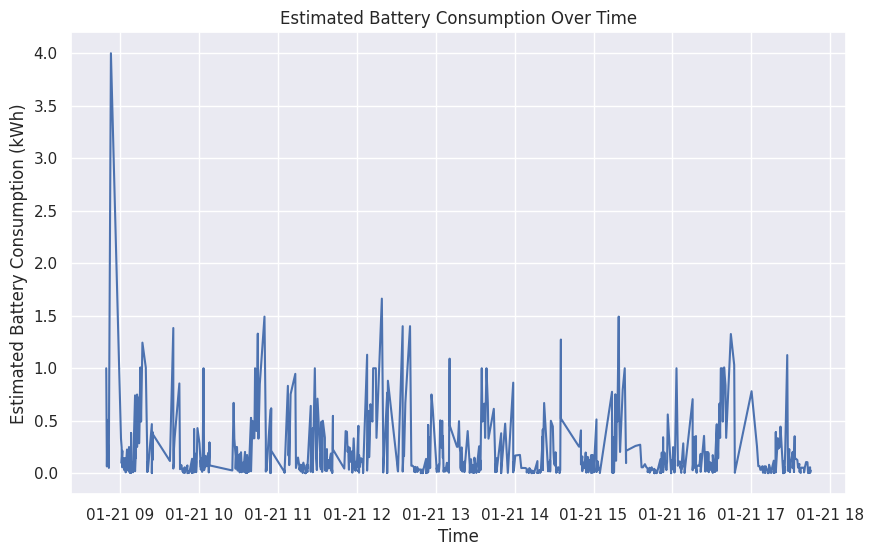

In [71]:
def visualize_over_time(attribute, vehicle, date):
    # Filter DataFrame
    df = dataset[(dataset['vehicle'] == vehicle) & (dataset['date'] == date)]

    plt.figure(figsize=(10, 6))
    plt.plot(df['t'], df[attribute], linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Estimated Battery Consumption (kWh)')
    plt.title('Estimated Battery Consumption Over Time')
    plt.grid(True)
    plt.savefig('segment-consumption.png', format='png')
    plt.show()

visualize_over_time('est_battery_consumption(kwh)', 'E301', pd.to_datetime('2024-01-21').date())

In [ ]:
result_df['shape'] = result_df['way_ids'].apply(lambda x: get_coordinates(db, x)['coordinates'])

In [ ]:
result_df['shape'] = result_df['shape'].apply(LineString)

In [ ]:
visualize = result_df[['vehicle', 'date', 'segment_consumption', 'shape','way_ids']]
visualize = visualize.rename(columns={'shape': 'geometry'})
visualize_gdf = gpd.GeoDataFrame(visualize, crs="EPSG:4326")
visualize_gdf['date'] = pd.to_datetime(visualize_gdf['date'])
visualize_gdf = visualize_gdf[visualize_gdf['date'] == pd.to_datetime('2024-01-21')]

In [ ]:
visualize_gdf[visualize_gdf['vehicle'] == 'E301']['segment_consumption'].sum()

In [ ]:
import keplergl as kp
map_1 = kp.KeplerGl(height=600, data={'consumption': visualize_gdf})
map_1

### Create baseline model from averaging the segment

In [5]:
segment_average = dataset[dataset['date'] < pd.to_datetime('2024-02-03').date()].groupby('road_segment_id')['est_battery_consumption(kwh)'].mean().reset_index()
segment_average  = segment_average.rename(columns={'est_battery_consumption(kwh)': 'average'})
segment_average

,road_segment_id,average
0,5199297,0.075058
1,5200756,0.086863
2,5208882,0.052943
3,5237773,0.080984
4,5239433,0.086665
...,...,...
735,1210150431,0.001421
736,1210150436,0.025905
737,1230235380,0.336957
738,1230235381,0.027010


#### Assign Prediction using average

In [6]:
pred_df = pd.merge(dataset, segment_average, on='road_segment_id')
pred_df = pred_df.groupby(['vehicle', 'date'])['average'].sum().reset_index()
pred_df

,vehicle,date,average
0,E301,2024-01-21,125.452949
1,E301,2024-01-22,155.861524
2,E301,2024-01-23,143.683155
3,E301,2024-01-24,76.434778
4,E301,2024-01-25,28.387552
...,...,...,...
258,E316,2024-02-04,81.680740
259,E316,2024-02-06,135.395161
260,E316,2024-02-07,150.032514
261,E316,2024-02-08,81.340667


#### Calculate the MSE for each day and each vehicle

In [7]:
gt_df = dataset.groupby(['vehicle', 'date'])['est_battery_consumption(kwh)'].sum().reset_index()
gt_df = gt_df.merge(pred_df, on=['vehicle', 'date'], how='inner')
gt_df = gt_df[gt_df['date'] >= pd.to_datetime('2024-02-03').date()]

gt_df.to_csv('./average.csv', index=False)

In [8]:
dataset.groupby(['vehicle', 'date', 't'])['road_segment_id'].count().reset_index()['road_segment_id'].mean()

2.182384802116973

In [9]:
y_true = gt_df['est_battery_consumption(kwh)'].values
y_pred = gt_df['average'].values

In [10]:
metrics.explained_variance_score(y_true, y_pred)

0.9014905406451552

In [11]:
metrics.r2_score(y_true, y_pred)

0.8814490916504412

In [12]:
metrics.mean_squared_error(y_true, y_pred)

175.98574777388322

#### Calculate for each vehicle

In [93]:
res = {'vehicle': [], 'mse': [], 'variance': [], 'r2': [], 'rmse': [], 'mape': [], 'mae': [], 'std': []}
for vehicle, group in gt_df[gt_df['date'] >= pd.to_datetime('2024-02-01').date()].groupby('vehicle'):
    group_true = group['est_battery_consumption(kwh)'].values
    group_pred = group['average']
    
    res['vehicle'].append(vehicle)
    res['mse'].append(metrics.mean_squared_error(group_true, group_pred))
    res['mape'].append(metrics.mean_absolute_percentage_error(group_true, group_pred))
    res['mae'].append(metrics.mean_absolute_error(group_true, group_pred))
    res['rmse'].append(math.sqrt(metrics.mean_squared_error(group_true, group_pred)))
    res['variance'].append(np.var(group_true - group_pred))
    res['std'].append(np.std(group_true - group_pred))
    res['r2'].append(metrics.r2_score(group_true, group_pred))

res_df = pd.DataFrame(res)
res_df

,vehicle,mse,variance,r2,rmse,mape,mae,std
0,E302,278.270836,175.177569,0.850141,16.681452,0.147212,12.687260,13.235466
1,E304,132.618356,32.705535,0.741513,11.516004,0.075677,9.995640,5.718875
2,E305,1364.695272,879.755011,0.458058,36.941782,0.387514,24.052318,29.660664
3,E306,203.208824,157.595266,0.855657,14.255133,0.142141,12.676061,12.553695
4,E307,107.508162,105.042392,0.892987,10.368614,0.080347,9.288339,10.249019
5,E308,115.528351,112.180404,0.888404,10.748412,0.077394,9.292355,10.591525
6,E309,53.220737,44.676189,0.962324,7.295254,0.051447,5.555606,6.684025
7,E310,43.368003,36.439390,0.978020,6.585439,0.069751,5.335858,6.036505
8,E311,117.070798,115.278011,0.898190,10.819926,0.114116,10.254465,10.736760
9,E312,219.537360,122.091897,0.809006,14.816793,0.112143,11.384000,11.049520


In [94]:
res = {'date': [], 'mse': [], 'variance': [], 'r2': [], 'rmse': [], 'mape': [], 'mae': [], 'std': []}
for date, group in gt_df[gt_df['date'] >= pd.to_datetime('2024-02-01').date()].groupby('date'):
    group_true = group['est_battery_consumption(kwh)'].values
    group_pred = group['average']
    res['date'].append(date)
    res['mse'].append(metrics.mean_squared_error(group_true, group_pred))
    res['mape'].append(metrics.mean_absolute_percentage_error(group_true, group_pred))
    res['mae'].append(metrics.mean_absolute_error(group_true, group_pred))
    res['rmse'].append(math.sqrt(metrics.mean_squared_error(group_true, group_pred)))
    res['variance'].append(np.var(group_true - group_pred))
    res['std'].append(np.std(group_true - group_pred))
    res['r2'].append(metrics.r2_score(group_true, group_pred))


res_date_df = pd.DataFrame(res)
res_date_df

,date,mse,variance,r2,rmse,mape,mae,std
0,2024-02-01,99.463158,99.235901,0.932670,9.973122,0.074476,7.934946,9.961722
1,2024-02-02,151.761770,127.206259,0.892860,12.319163,0.101537,8.103792,11.278575
2,2024-02-03,407.109484,336.013077,0.733057,20.176954,0.097126,9.855235,18.330659
3,2024-02-04,79.676474,70.982771,0.907603,8.926168,0.174740,7.829871,8.425127
4,2024-02-06,193.653293,101.262414,0.779352,13.915937,0.112534,11.892064,10.062923
5,2024-02-07,91.060583,46.382683,0.927518,9.542567,0.078823,7.925822,6.810483
6,2024-02-08,166.958144,124.058312,0.888423,12.921228,0.103137,11.198556,11.138147
7,2024-02-09,97.948854,97.655875,0.904665,9.896911,0.069386,8.523772,9.882099


#### Prepare data for regression model
Based on this model we can build a model to explain segment consumption, this way we can estimate the real consumption of each segment. First we need to build up our dataset by adding elevation and weather data

#### Getting elevation from road segment

In [31]:
road_segments = db.get_all_waypoints()
road_segments = road_segments.explode('coordinates')
road_segments = road_segments[['id', 'coordinates']]
road_segments['longitude'] = road_segments['coordinates'].apply(lambda x: x[0])
road_segments['latitude'] = road_segments['coordinates'].apply(lambda x: x[1])
road_segments = road_segments.reset_index()

In [32]:
road_segments.drop(columns=['coordinates', 'index'], inplace=True)
road_segments.to_csv('../processed_data/road_segments.csv')

#### Calculate mean slope and mean elevation of a road segment

In [5]:
segments_exploded = pd.read_csv('../processed_data/road_segment_elevation.csv').sort_values(by=['idx'])
segments_exploded['latitude'] = segments_exploded['latitude'].astype(float)
segments_exploded['longitude'] = segments_exploded['longitude'].astype(float)
segments_exploded['elevation'] = segments_exploded['elevation'].astype(float)                                                                 

In [6]:
def calculate_mean_slope_with_elevation(group):
    group = group.sort_values(by=['idx'])
    coords = list(zip(group['latitude'], group['longitude'], group['elevation']))
    real_coords = list(zip(group['longitude'], group['latitude'], group['elevation']))
    
    grades = []
    angles = []
    
    for i in range(1, len(coords)):
        start = coords[i-1]
        end = coords[i]
        
        # Calculate horizontal distance using geodesic
        horizontal_distance = geodesic((start[0], start[1]), (end[0], end[1])).meters
        
        # Calculate elevation change
        elevation_change = end[2] - start[2]
        
        if horizontal_distance != 0:
            grade = (elevation_change / horizontal_distance) * 100
            angle = np.degrees(np.arctan(grade / 100))
            
            grades.append(grade)
            angles.append(angle)
    
    # Calculate the mean grade and angle
    mean_grade = np.mean(grades) if grades else 0.0
    mean_angle = np.mean(angles) if angles else 0.0
    
    return mean_grade, mean_angle, real_coords

# Example usage with segments_exploded DataFrame
# Assuming segments_exploded DataFrame is already defined and contains 'segment_id', 'latitude', 'longitude', 'elevation', and 'idx' columns

slopes_and_elev = segments_exploded.groupby('segment_id').apply(
    lambda group: pd.Series({
        'grade_angle': calculate_mean_slope_with_elevation(group),
        'mean_elevation': group['elevation'].mean()
    })
).reset_index()

slopes_and_elev['avg_grade'] = slopes_and_elev['grade_angle'].apply(lambda x: x[0])
slopes_and_elev['avg_angle'] = slopes_and_elev['grade_angle'].apply(lambda x: x[1])
slopes_and_elev['geometry'] = slopes_and_elev['grade_angle'].apply(lambda x: LineString(x[2]))
slopes_and_elev.drop(columns=['grade_angle'], inplace=True)

slopes_and_elev

/tmp/ipykernel_84106/4114932399.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_and_elev = segments_exploded.groupby('segment_id').apply(


,segment_id,mean_elevation,avg_grade,avg_angle,geometry
0,4478294,16.644777,0.729125,0.417446,LINESTRING Z (8.9300571 44.4132844 14.76128959...
1,4478353,32.943430,1.355885,0.772383,LINESTRING Z (8.9384153 44.4098851 32.29840850...
2,4859191,9.627326,0.922425,0.528495,LINESTRING Z (8.9412848 44.4054891 9.458243370...
3,5199297,9.393306,-0.260103,-0.149023,LINESTRING Z (8.9544188 44.4024499 9.423381805...
4,5200756,9.863290,-0.327972,-0.187910,LINESTRING Z (8.9550315 44.4047539 10.04360008...
...,...,...,...,...,...
1998,1254847324,14.563320,0.677970,0.388395,LINESTRING Z (8.8933303 44.4287115 14.38726043...
1999,1254866907,14.145086,0.243015,0.139237,LINESTRING Z (8.891959 44.4317155 13.261449813...
2000,1254866908,28.274405,0.553450,0.317055,LINESTRING Z (8.8920123 44.4391541 27.56303977...
2001,1254866909,27.077168,0.361465,0.207069,LINESTRING Z (8.8938317 44.4469103 27.18993949...


In [7]:
slopes_and_elev.describe()

,segment_id,mean_elevation,avg_grade,avg_angle
count,2.003000e+03,2003.000000,2003.000000,2003.000000
mean,3.543430e+08,28.287260,-0.135304,-0.052131
std,3.436905e+08,26.103984,7.612232,3.857694
min,4.478294e+06,0.900162,-105.027914,-46.404787
25%,4.215202e+07,8.152456,-1.773574,-1.000736
50%,2.128136e+08,17.977244,0.000000,0.000000
75%,5.585565e+08,44.008987,1.497972,0.854719
max,1.267748e+09,135.482666,51.951951,24.489986


#### Import weather data

In [35]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 44.404799,
	"longitude": 8.9444,
	"start_date": "2024-01-20",
	"end_date": "2024-02-09",
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", "wind_speed_10m", "wind_direction_10m", "soil_temperature_0_to_7cm", "soil_moisture_0_to_7cm", "is_day", "sunshine_duration"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

In [36]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(6).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(7).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(8).ValuesAsNumpy()
hourly_is_day = hourly.Variables(9).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(10).ValuesAsNumpy()

hourly_data = {"datetime": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration

hourly_dataframe = pd.DataFrame(data = hourly_data)

hourly_dataframe['datetime'] = hourly_dataframe['datetime'].dt.tz_convert('UTC').dt.tz_localize(None)

hourly_dataframe

Coordinates 44.393672943115234°N 9.096477508544922°E
Elevation 18.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s


,datetime,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,wind_speed_10m,wind_direction_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,is_day,sunshine_duration
0,2024-01-19 22:00:00,6.583000,38.657471,0.0,0.0,0.0,36.204617,48.224621,9.683000,0.400,0.0,0.0
1,2024-01-19 23:00:00,6.233000,36.953403,0.0,0.0,0.0,31.205997,39.382397,9.382999,0.400,0.0,0.0
2,2024-01-20 00:00:00,5.983000,34.122253,0.0,0.0,0.0,29.764839,32.152271,9.083000,0.400,0.0,0.0
3,2024-01-20 01:00:00,6.533000,30.140131,0.0,0.0,0.0,27.609911,22.217653,10.533000,0.400,0.0,0.0
4,2024-01-20 02:00:00,6.033000,32.192905,0.0,0.0,0.0,28.220417,23.294596,9.832999,0.399,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
499,2024-02-09 17:00:00,12.183000,88.762115,3.1,3.1,0.0,25.364037,186.519699,12.183000,0.430,0.0,0.0
500,2024-02-09 18:00:00,11.733000,87.837677,1.5,1.5,0.0,24.122683,180.855072,11.783000,0.430,0.0,0.0
501,2024-02-09 19:00:00,11.783000,87.548378,2.1,2.1,0.0,24.826952,163.141525,11.582999,0.430,0.0,0.0
502,2024-02-09 20:00:00,11.733000,89.320213,1.8,1.8,0.0,23.006226,159.863617,11.433000,0.430,0.0,0.0


#### Add weather to data

In [37]:
dataset_df = pd.merge_asof(dataset.sort_values('t'), hourly_dataframe.sort_values('datetime'), left_on='t', right_on='datetime')

In [38]:
dataset_df = pd.merge(dataset_df, slopes_and_elev, left_on='road_segment_id', right_on='segment_id')
dataset_df = dataset_df.sort_values(['vehicle', 't'])
dataset_df[['t', 'temperature_2m', 'precipitation', 'wind_speed_10m']]

,t,temperature_2m,precipitation,wind_speed_10m
17222,2024-01-21 08:49:19,4.683000,0.0,10.483357
17224,2024-01-21 08:49:49,4.683000,0.0,10.483357
17225,2024-01-21 08:49:49,4.683000,0.0,10.483357
17226,2024-01-21 08:49:49,4.683000,0.0,10.483357
17230,2024-01-21 08:50:19,4.683000,0.0,10.483357
...,...,...,...,...
299368,2024-02-09 20:59:31,11.733000,1.8,23.006226
299369,2024-02-09 21:00:01,12.082999,2.5,24.905132
299370,2024-02-09 21:01:03,12.082999,2.5,24.905132
299371,2024-02-09 21:01:03,12.082999,2.5,24.905132


In [39]:
dataset_df.to_csv('../processed_data/cleaned_dataset_v2.csv',index=False)

In [65]:
gdf = gpd.GeoDataFrame(dataset_df, crs="EPSG:4326")
gdf = gdf.iloc[1:200]
import keplergl as kp
map_1 = kp.KeplerGl(hedaight=600, data={'consumption': gdf[['t', '']]})
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'consumption':        road_segment_id  avg_grade_y  mean_elevation_y  \
17224        211285373 …

In [16]:
dataset_df = pd.read_csv('../processed_data/dataset_cleaned_v4.csv')
dataset_df['date'] = pd.to_datetime(dataset_df['date']).dt.date

In [59]:
dataset_start = consumption_data.groupby(['vehicle', 'date'])['value'].first().reset_index()
real_start = consumption_df.groupby(['vehicle', 'date'])['value'].first().reset_index()
diff = pd.merge(dataset_start, real_start, on=['vehicle', 'date']).rename(columns={'value_x': 'data_start', 'value_y': 'real_start'})
diff['diff'] = diff['data_start'] - diff['real_start']

In [60]:
data = dataset_df.groupby(['vehicle', 'date'])['est_battery_consumption(kwh)'].sum().reset_index()
data

,vehicle,date,est_battery_consumption(kwh)
0,E301,2024-01-21,144.980232
1,E301,2024-01-22,166.020985
2,E301,2024-01-23,153.449511
3,E301,2024-01-24,91.742738
4,E301,2024-01-25,24.907494
...,...,...,...
258,E316,2024-02-04,67.097611
259,E316,2024-02-06,120.491253
260,E316,2024-02-07,146.965740
261,E316,2024-02-08,78.660132


In [61]:
real = consumption_df.groupby(['vehicle', 'date'])['value'].max().reset_index()
real.sort_values('value')

,vehicle,date,value
100,E308,2024-01-26,0.0
34,E304,2024-01-30,0.0
7,E301,2024-01-29,3.0
98,E308,2024-01-24,5.0
57,E305,2024-02-04,8.0
...,...,...,...
31,E304,2024-01-26,171.0
250,E316,2024-01-22,172.0
154,E311,2024-01-22,175.0
25,E304,2024-01-20,180.0


In [62]:
compare = pd.merge(real, data, on=['vehicle', 'date'])
compare = pd.merge(compare, diff, on=['vehicle', 'date'])
compare

,vehicle,date,value,est_battery_consumption(kwh),data_start,real_start,diff
0,E301,2024-01-21,145.0,144.980232,0.0,0.0,0.0
1,E301,2024-01-22,165.0,166.020985,0.0,0.0,0.0
2,E301,2024-01-23,153.0,153.449511,1.0,0.0,1.0
3,E301,2024-01-24,92.0,91.742738,0.0,0.0,0.0
4,E301,2024-01-25,26.0,24.907494,1.0,0.0,1.0
...,...,...,...,...,...,...,...
258,E316,2024-02-04,66.0,67.097611,0.0,0.0,0.0
259,E316,2024-02-06,121.0,120.491253,1.0,0.0,1.0
260,E316,2024-02-07,148.0,146.965740,1.0,0.0,1.0
261,E316,2024-02-08,79.0,78.660132,1.0,0.0,1.0


In [63]:
compare['est_total'] = abs(compare['est_battery_consumption(kwh)'] + compare['diff'])

In [64]:
compare['variance'] = abs(compare['est_total'] - compare['value'])
compare.sort_values('variance', ascending=False)

,vehicle,date,value,est_battery_consumption(kwh),data_start,real_start,diff,est_total,variance
14,E302,2024-01-29,36.0,32.032344,5.0,4.0,1.0,33.032344,2.967656
98,E308,2024-01-29,44.0,38.442521,3.0,0.0,3.0,41.442521,2.557479
99,E308,2024-01-30,44.0,40.538531,1.0,0.0,1.0,41.538531,2.461469
174,E312,2024-01-27,11.0,12.999976,0.0,0.0,0.0,12.999976,1.999976
110,E309,2024-01-21,74.0,75.999655,0.0,0.0,0.0,75.999655,1.999655
...,...,...,...,...,...,...,...,...,...
12,E302,2024-01-25,98.0,96.002550,2.0,0.0,2.0,98.002550,0.002550
109,E309,2024-01-20,187.0,186.002517,1.0,0.0,1.0,187.002517,0.002517
113,E309,2024-01-24,47.0,46.999928,0.0,0.0,0.0,46.999928,0.000072
142,E310,2024-02-03,25.0,24.999982,0.0,0.0,0.0,24.999982,0.000018


In [65]:
compare['variance'].describe()

count    263.000000
mean       0.815476
std        0.578912
min        0.000000
25%        0.251267
50%        0.952279
75%        1.157936
max        2.967656
Name: variance, dtype: float64

In [68]:
consumption_matched_gdf[(consumption_matched_gdf['vehicle'] == 'E302') & (consumption_matched_gdf['date'] == pd.to_datetime('2024-01-29').date())].head(50)

,vehicle,t,signal,value,way_ids,length,distance_along_edge,date,trip_id,geometry,diff
10605,E302,2024-01-29 11:35:21,lastDayTotalConsumedEnergy,4.0,[553983725],"[(553983725, 0.014)]",0.000000,2024-01-29,trip_6,POINT (8.94558 44.40023),1.0
10606,E302,2024-01-29 11:36:23,lastDayTotalConsumedEnergy,4.0,[211285373],"[(211285373, 0.064)]",0.530483,2024-01-29,trip_6,POINT (8.94577 44.40064),1.0
10607,E302,2024-01-29 11:36:54,lastDayTotalConsumedEnergy,4.0,"[19784065, 474230989]","[(19784065, 0.049), (474230989, 0.014)]",0.083341,2024-01-29,trip_6,POINT (8.94591 44.40093),1.0
10608,E302,2024-01-29 11:37:25,lastDayTotalConsumedEnergy,4.0,"[553819742, 557313439, 53817770]","[(553819742, 0.074), (557313439, 0.032), (5381...",0.677403,2024-01-29,trip_6,POINT (8.94620 44.40187),1.0
10609,E302,2024-01-29 11:37:56,lastDayTotalConsumedEnergy,4.0,"[53817787, 19639754, 441875218, 5368571]","[(53817787, 0.067), (19639754, 0.017), (441875...",0.427933,2024-01-29,trip_6,POINT (8.94566 44.40131),1.0
10610,E302,2024-01-29 11:38:57,lastDayTotalConsumedEnergy,5.0,[278624956],"[(278624956, 0.863)]",0.073084,2024-01-29,trip_6,POINT (8.94417 44.39908),1.0
10611,E302,2024-01-29 11:39:27,lastDayTotalConsumedEnergy,5.0,[278624956],"[(278624956, 0.863)]",0.488432,2024-01-29,trip_6,POINT (8.94150 44.39688),1.0
10612,E302,2024-01-29 11:39:57,lastDayTotalConsumedEnergy,6.0,[278624956],"[(278624956, 0.863)]",0.757573,2024-01-29,trip_6,POINT (8.93888 44.39772),1.0
10613,E302,2024-01-29 11:40:28,lastDayTotalConsumedEnergy,6.0,"[76701716, 967248341]","[(76701716, 0.035), (967248341, 0.009)]",0.582733,2024-01-29,trip_6,POINT (8.93950 44.39776),1.0
10614,E302,2024-01-29 11:42:01,lastDayTotalConsumedEnergy,6.0,[76701715],"[(76701715, 0.224)]",0.185712,2024-01-29,trip_6,POINT (8.94023 44.39795),1.0


In [6]:
dataset_df = pd.read_csv('../processed_data/cleaned_dataset.csv')
dataset_df['date'] = pd.to_datetime(dataset_df['date']).dt.date
dataset_df['t'] = pd.to_datetime(dataset_df['t'])
dataset_df

,vehicle,t,road_segment_id,est_segment_battery_consumption(kwh),est_battery_consumption(kwh),date,segment_length,distance_traveled,trip_id,datetime,...,wind_direction_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,is_day,sunshine_duration,segment_id,mean_elevation,avg_grade,avg_angle,geometry
0,E301,2024-01-21 08:49:19,553983725,8.833500,1.000000,2024-01-21,14.361187,1.625764,trip_20,2024-01-21 08:00:00,...,15.945477,5.733000,0.394,1.0,2082.4731,553983725,8.699299,-1.343470,-0.769706,LINESTRING Z (8.9455802 44.400228 8.7958431243...
1,E301,2024-01-21 08:49:49,211285373,0.295673,0.199855,2024-01-21,63.803733,43.126976,trip_20,2024-01-21 08:00:00,...,15.945477,5.733000,0.394,1.0,2082.4731,211285373,8.543800,-0.184659,-0.105802,LINESTRING Z (8.9456338 44.4003515 8.602755546...
2,E301,2024-01-21 08:49:49,19784065,0.227071,0.227071,2024-01-21,48.896393,49.000000,trip_20,2024-01-21 08:00:00,...,15.945477,5.733000,0.394,1.0,2082.4731,19784065,8.391276,-0.414343,-0.237398,LINESTRING Z (8.945892 44.4008955 8.4848451614...
3,E301,2024-01-21 08:49:49,474230989,0.064877,0.064877,2024-01-21,13.874596,14.000000,trip_20,2024-01-21 08:00:00,...,15.945477,5.733000,0.394,1.0,2082.4731,474230989,8.100567,-1.743121,-0.998634,LINESTRING Z (8.9460857 44.4013134 8.221586227...
4,E301,2024-01-21 08:50:19,553819742,0.687729,0.508197,2024-01-21,74.361373,54.949292,trip_20,2024-01-21 08:00:00,...,15.945477,5.733000,0.394,1.0,2082.4731,553819742,7.554913,-0.185431,-0.106138,LINESTRING Z (8.946138 44.4014326 7.9795479774...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299368,E316,2024-02-09 20:59:31,24313581,0.126971,0.086648,2024-02-09,170.122166,116.095320,trip_490,2024-02-09 20:00:00,...,159.863620,11.433000,0.430,0.0,0.0000,24313581,7.030001,-1.636248,-0.937297,LINESTRING Z (8.9517899 44.4044109 8.780200958...
299369,E316,2024-02-09 21:00:01,136531734,0.078096,0.044034,2024-02-09,145.945283,82.290272,trip_490,2024-02-09 21:00:00,...,184.144550,11.382999,0.430,0.0,0.0000,136531734,4.867664,-1.057230,-0.605723,LINESTRING Z (8.9511136 44.4029576 5.404003143...
299370,E316,2024-02-09 21:01:03,274100607,0.100566,0.060344,2024-02-09,97.871372,58.727186,trip_490,2024-02-09 21:00:00,...,184.144550,11.382999,0.430,0.0,0.0000,274100607,3.865974,-1.577247,-0.903525,LINESTRING Z (8.9505306 44.4017114 4.052059173...
299371,E316,2024-02-09 21:01:03,274100606,0.029994,0.029994,2024-02-09,108.217493,108.000000,trip_490,2024-02-09 21:00:00,...,184.144550,11.382999,0.430,0.0,0.0000,274100606,3.217747,-0.013462,-0.007713,LINESTRING Z (8.9501388 44.4008759 3.629924058...


In [11]:
speed = pd.read_csv('../processed_data/speed.csv')
# Remove the timezone information by converting to string and then to datetime
speed['t'] = pd.to_datetime(speed['t'].astype(str).str[:-6], errors='coerce')
speed['date'] =  pd.to_datetime(speed['date']).dt.date
speed

,vehicle,date,trip_id,t,speed_meos
0,E301,2024-01-21,stop_0,2024-01-21 08:16:26,0.064399
1,E301,2024-01-21,stop_0,2024-01-21 08:18:27,0.025046
2,E301,2024-01-21,stop_0,2024-01-21 08:18:58,0.035115
3,E301,2024-01-21,stop_0,2024-01-21 08:19:28,0.006629
4,E301,2024-01-21,stop_0,2024-01-21 08:40:40,0.021333
...,...,...,...,...,...
311018,E316,2024-02-09,trip_83,2024-02-09 07:43:37,1.802069
311019,E316,2024-02-09,trip_83,2024-02-09 07:44:08,3.238795
311020,E316,2024-02-09,trip_83,2024-02-09 07:44:38,1.442857
311021,E316,2024-02-09,trip_83,2024-02-09 07:45:09,1.787026


In [15]:
dataset_df = pd.merge(dataset_df, speed, on=['vehicle', 'date', 'trip_id', 't'], how="left")

In [16]:
dataset_df.to_csv('../processed_data/dataset_cleaned_v4.csv')

In [17]:
dataset_df[]

,Unnamed: 0,vehicle,t,road_segment_id,est_segment_battery_consumption(kwh),est_battery_consumption(kwh),date,segment_length,distance_traveled,trip_id,...,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,is_day,sunshine_duration,segment_id,mean_elevation,avg_grade,avg_angle,geometry,speed_meos
0,0,E301,2024-01-21 08:49:19,553983725,8.833500,1.000000,2024-01-21,14.361187,1.625764,trip_20,...,5.733000,0.394,1.0,2082.4731,553983725,8.699299,-1.343470,-0.769706,LINESTRING Z (8.9455802 44.400228 8.7958431243...,1.954289
1,1,E301,2024-01-21 08:49:49,211285373,0.295673,0.199855,2024-01-21,63.803733,43.126976,trip_20,...,5.733000,0.394,1.0,2082.4731,211285373,8.543800,-0.184659,-0.105802,LINESTRING Z (8.9456338 44.4003515 8.602755546...,4.564982
2,2,E301,2024-01-21 08:49:49,19784065,0.227071,0.227071,2024-01-21,48.896393,49.000000,trip_20,...,5.733000,0.394,1.0,2082.4731,19784065,8.391276,-0.414343,-0.237398,LINESTRING Z (8.945892 44.4008955 8.4848451614...,4.564982
3,3,E301,2024-01-21 08:49:49,474230989,0.064877,0.064877,2024-01-21,13.874596,14.000000,trip_20,...,5.733000,0.394,1.0,2082.4731,474230989,8.100567,-1.743121,-0.998634,LINESTRING Z (8.9460857 44.4013134 8.221586227...,4.564982
4,4,E301,2024-01-21 08:50:19,553819742,0.687729,0.508197,2024-01-21,74.361373,54.949292,trip_20,...,5.733000,0.394,1.0,2082.4731,553819742,7.554913,-0.185431,-0.106138,LINESTRING Z (8.946138 44.4014326 7.9795479774...,0.877952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299368,299368,E316,2024-02-09 20:59:31,24313581,0.126971,0.086648,2024-02-09,170.122166,116.095320,trip_490,...,11.433000,0.430,0.0,0.0000,24313581,7.030001,-1.636248,-0.937297,LINESTRING Z (8.9517899 44.4044109 8.780200958...,3.405764
299369,299369,E316,2024-02-09 21:00:01,136531734,0.078096,0.044034,2024-02-09,145.945283,82.290272,trip_490,...,11.382999,0.430,0.0,0.0000,136531734,4.867664,-1.057230,-0.605723,LINESTRING Z (8.9511136 44.4029576 5.404003143...,2.858950
299370,299370,E316,2024-02-09 21:01:03,274100607,0.100566,0.060344,2024-02-09,97.871372,58.727186,trip_490,...,11.382999,0.430,0.0,0.0000,274100607,3.865974,-1.577247,-0.903525,LINESTRING Z (8.9505306 44.4017114 4.052059173...,0.034098
299371,299371,E316,2024-02-09 21:01:03,274100606,0.029994,0.029994,2024-02-09,108.217493,108.000000,trip_490,...,11.382999,0.430,0.0,0.0000,274100606,3.217747,-0.013462,-0.007713,LINESTRING Z (8.9501388 44.4008759 3.629924058...,0.034098


In [27]:
filtered_df = dataset_df.merge(reset_dates_info, on=['vehicle', 'date'], how='left', indicator=True)
filtered_df = filtered_df[filtered_df['_merge'] == 'left_only'].drop(columns=['_merge'])
filtered_df.drop(columns=['Unnamed: 0']).to_csv('../processed_data/dataset_cleaned_v5.csv', index=False)

In [25]:
filtered_df

,Unnamed: 0,vehicle,t,road_segment_id,est_segment_battery_consumption(kwh),est_battery_consumption(kwh),date,segment_length,distance_traveled,trip_id,...,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,is_day,sunshine_duration,segment_id,mean_elevation,avg_grade,avg_angle,geometry,speed_meos
0,0,E301,2024-01-21 08:49:19,553983725,8.833500,1.000000,2024-01-21,14.361187,1.625764,trip_20,...,5.733000,0.394,1.0,2082.4731,553983725,8.699299,-1.343470,-0.769706,LINESTRING Z (8.9455802 44.400228 8.7958431243...,1.954289
1,1,E301,2024-01-21 08:49:49,211285373,0.295673,0.199855,2024-01-21,63.803733,43.126976,trip_20,...,5.733000,0.394,1.0,2082.4731,211285373,8.543800,-0.184659,-0.105802,LINESTRING Z (8.9456338 44.4003515 8.602755546...,4.564982
2,2,E301,2024-01-21 08:49:49,19784065,0.227071,0.227071,2024-01-21,48.896393,49.000000,trip_20,...,5.733000,0.394,1.0,2082.4731,19784065,8.391276,-0.414343,-0.237398,LINESTRING Z (8.945892 44.4008955 8.4848451614...,4.564982
3,3,E301,2024-01-21 08:49:49,474230989,0.064877,0.064877,2024-01-21,13.874596,14.000000,trip_20,...,5.733000,0.394,1.0,2082.4731,474230989,8.100567,-1.743121,-0.998634,LINESTRING Z (8.9460857 44.4013134 8.221586227...,4.564982
4,4,E301,2024-01-21 08:50:19,553819742,0.687729,0.508197,2024-01-21,74.361373,54.949292,trip_20,...,5.733000,0.394,1.0,2082.4731,553819742,7.554913,-0.185431,-0.106138,LINESTRING Z (8.946138 44.4014326 7.9795479774...,0.877952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299368,299368,E316,2024-02-09 20:59:31,24313581,0.126971,0.086648,2024-02-09,170.122166,116.095320,trip_490,...,11.433000,0.430,0.0,0.0000,24313581,7.030001,-1.636248,-0.937297,LINESTRING Z (8.9517899 44.4044109 8.780200958...,3.405764
299369,299369,E316,2024-02-09 21:00:01,136531734,0.078096,0.044034,2024-02-09,145.945283,82.290272,trip_490,...,11.382999,0.430,0.0,0.0000,136531734,4.867664,-1.057230,-0.605723,LINESTRING Z (8.9511136 44.4029576 5.404003143...,2.858950
299370,299370,E316,2024-02-09 21:01:03,274100607,0.100566,0.060344,2024-02-09,97.871372,58.727186,trip_490,...,11.382999,0.430,0.0,0.0000,274100607,3.865974,-1.577247,-0.903525,LINESTRING Z (8.9505306 44.4017114 4.052059173...,0.034098
299371,299371,E316,2024-02-09 21:01:03,274100606,0.029994,0.029994,2024-02-09,108.217493,108.000000,trip_490,...,11.382999,0.430,0.0,0.0000,274100606,3.217747,-0.013462,-0.007713,LINESTRING Z (8.9501388 44.4008759 3.629924058...,0.034098
